In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> V1 !!!!! K-Fold Training and Evaluation</h2>

In [13]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=16,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(96)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(32)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [14]:
model = build_current_model()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 85, 16)        2368      
_________________________________________________________________
batch_normalization_35 (Batc (None, 56, 85, 16)        64        
_________________________________________________________________
activation_35 (Activation)   (None, 56, 85, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 43, 16)        0         
_________________________________________________________________
spatial_dropout2d_20 (Spatia (None, 28, 43, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 22, 64)        2566

In [15]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.2,
              verbose=2,
              callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/70
272/272 - 2s - loss: 1.5259 - accuracy: 0.5299 - val_loss: 2.0174 - val_accuracy: 0.2445
Epoch 2/70
272/272 - 2s - loss: 1.4276 - accuracy: 0.5571 - val_loss: 1.5595 - val_accuracy: 0.5221
Epoch 3/70
272/272 - 3s - loss: 1.3559 - accuracy: 0.5635 - val_loss: 1.6156 - val_accuracy: 0.5312
Epoch 4/70
272/272 - 3s - loss: 1.2866 - accuracy: 0.5718 - val_loss: 1.2285 - val_accuracy: 0.5533
Epoch 5/70
272/272 - 2s - loss: 1.2370 - accuracy: 0.5852 - val_loss: 1.8916 - val_accuracy: 0.5221
Epoch 6/70
272/272 - 2s - loss: 1.1860 - accuracy: 0.5907 - val_loss: 1.2664 - val_accuracy: 0.5515
Epoch 7/70
272/272 - 2s - loss: 1.1356 - accuracy: 0.6068 - val_loss: 2.6680 - val_accuracy: 0.5221
Epoch 8/70
272/272 - 2s - loss: 1.0762 - accuracy: 0.6303 - val_loss: 1.0543 - val_accuracy: 0.6066
Epoch 9/70
272/272 - 2s - loss: 1.0196 - accuracy: 0.6372 - val_loss: 0.9949 - val_accuracy: 0.6195
Epoch 10/70
272/272 - 2s - loss: 0.9972 - accuracy: 0.6561 - val_loss: 0.8517 - val_accuracy: 0.6765

Epoch 26/70
272/272 - 2s - loss: 0.5058 - accuracy: 0.8370 - val_loss: 0.6138 - val_accuracy: 0.7445
Epoch 27/70
272/272 - 2s - loss: 0.4944 - accuracy: 0.8370 - val_loss: 0.5975 - val_accuracy: 0.8033
Epoch 28/70
272/272 - 2s - loss: 0.4859 - accuracy: 0.8485 - val_loss: 0.3856 - val_accuracy: 0.8695
Epoch 29/70
272/272 - 2s - loss: 0.4477 - accuracy: 0.8531 - val_loss: 0.9534 - val_accuracy: 0.6654
Epoch 30/70
272/272 - 2s - loss: 0.4468 - accuracy: 0.8564 - val_loss: 0.6623 - val_accuracy: 0.7555
Epoch 31/70
272/272 - 2s - loss: 0.4922 - accuracy: 0.8421 - val_loss: 0.6170 - val_accuracy: 0.7757
Epoch 32/70
272/272 - 2s - loss: 0.4246 - accuracy: 0.8600 - val_loss: 0.4069 - val_accuracy: 0.8658
Epoch 33/70
272/272 - 2s - loss: 0.4247 - accuracy: 0.8536 - val_loss: 0.4926 - val_accuracy: 0.8107
Epoch 34/70
272/272 - 2s - loss: 0.4399 - accuracy: 0.8536 - val_loss: 0.5067 - val_accuracy: 0.8125
Epoch 35/70
272/272 - 2s - loss: 0.3892 - accuracy: 0.8706 - val_loss: 0.3345 - val_accurac

Epoch 38/70
272/272 - 2s - loss: 0.3743 - accuracy: 0.8743 - val_loss: 0.3595 - val_accuracy: 0.8768
Epoch 39/70
272/272 - 2s - loss: 0.3826 - accuracy: 0.8757 - val_loss: 0.8448 - val_accuracy: 0.7335
Epoch 40/70
272/272 - 2s - loss: 0.4380 - accuracy: 0.8554 - val_loss: 0.4155 - val_accuracy: 0.8382
Epoch 41/70
272/272 - 2s - loss: 0.4194 - accuracy: 0.8646 - val_loss: 0.4275 - val_accuracy: 0.8511
Epoch 42/70
272/272 - 2s - loss: 0.3701 - accuracy: 0.8817 - val_loss: 0.3433 - val_accuracy: 0.8824
Epoch 43/70
272/272 - 2s - loss: 0.3423 - accuracy: 0.8817 - val_loss: 0.3002 - val_accuracy: 0.8971
Epoch 44/70
272/272 - 2s - loss: 0.3311 - accuracy: 0.8867 - val_loss: 0.3907 - val_accuracy: 0.8676
Epoch 45/70
272/272 - 2s - loss: 0.3704 - accuracy: 0.8785 - val_loss: 0.3542 - val_accuracy: 0.8860
Epoch 46/70
272/272 - 2s - loss: 0.3546 - accuracy: 0.8785 - val_loss: 0.4214 - val_accuracy: 0.8456
Epoch 47/70
272/272 - 2s - loss: 0.3766 - accuracy: 0.8771 - val_loss: 0.3699 - val_accurac

Epoch 50/70
272/272 - 2s - loss: 0.3717 - accuracy: 0.8849 - val_loss: 1.4623 - val_accuracy: 0.4669
Epoch 51/70
272/272 - 2s - loss: 0.3913 - accuracy: 0.8738 - val_loss: 0.8829 - val_accuracy: 0.7022
Epoch 52/70
272/272 - 3s - loss: 0.3453 - accuracy: 0.8900 - val_loss: 0.3981 - val_accuracy: 0.8732
Epoch 53/70
272/272 - 2s - loss: 0.3213 - accuracy: 0.8950 - val_loss: 0.3242 - val_accuracy: 0.8952
Epoch 54/70
272/272 - 2s - loss: 0.3458 - accuracy: 0.8890 - val_loss: 0.3580 - val_accuracy: 0.8713
Epoch 55/70
272/272 - 2s - loss: 0.3321 - accuracy: 0.8913 - val_loss: 0.4756 - val_accuracy: 0.8382
Epoch 56/70
272/272 - 2s - loss: 0.3194 - accuracy: 0.8895 - val_loss: 0.7256 - val_accuracy: 0.7463
Epoch 57/70
272/272 - 2s - loss: 0.2936 - accuracy: 0.9015 - val_loss: 0.2907 - val_accuracy: 0.9136
Epoch 58/70
272/272 - 2s - loss: 0.2982 - accuracy: 0.9065 - val_loss: 0.2751 - val_accuracy: 0.9118
Epoch 59/70
272/272 - 2s - loss: 0.3329 - accuracy: 0.8927 - val_loss: 0.4756 - val_accurac

Epoch 62/70
272/272 - 2s - loss: 0.2771 - accuracy: 0.9061 - val_loss: 0.5001 - val_accuracy: 0.8309
Epoch 63/70
272/272 - 2s - loss: 0.2894 - accuracy: 0.9033 - val_loss: 0.2661 - val_accuracy: 0.9154
Epoch 64/70
272/272 - 2s - loss: 0.2748 - accuracy: 0.9121 - val_loss: 0.3428 - val_accuracy: 0.8915
Epoch 65/70
272/272 - 2s - loss: 0.3034 - accuracy: 0.9056 - val_loss: 0.3178 - val_accuracy: 0.8897
Epoch 66/70
272/272 - 2s - loss: 0.2697 - accuracy: 0.9134 - val_loss: 0.3606 - val_accuracy: 0.8805
Epoch 67/70
272/272 - 2s - loss: 0.2520 - accuracy: 0.9185 - val_loss: 0.4534 - val_accuracy: 0.8732
Epoch 68/70
272/272 - 2s - loss: 0.2816 - accuracy: 0.9162 - val_loss: 0.3063 - val_accuracy: 0.9062
Epoch 69/70
272/272 - 2s - loss: 0.3127 - accuracy: 0.9010 - val_loss: 0.4637 - val_accuracy: 0.8235
Epoch 70/70
272/272 - 3s - loss: 0.2636 - accuracy: 0.9199 - val_loss: 0.3147 - val_accuracy: 0.8897
Epoch 1/70
272/272 - 2s - loss: 1.5896 - accuracy: 0.5207 - val_loss: 1.4860 - val_accuracy

Epoch 3/70
272/272 - 2s - loss: 1.3494 - accuracy: 0.5677 - val_loss: 2.8694 - val_accuracy: 0.5221
Epoch 4/70
272/272 - 2s - loss: 1.2989 - accuracy: 0.5654 - val_loss: 1.5967 - val_accuracy: 0.5386
Epoch 5/70
272/272 - 2s - loss: 1.2965 - accuracy: 0.5746 - val_loss: 1.5872 - val_accuracy: 0.5202
Epoch 6/70
272/272 - 2s - loss: 1.2449 - accuracy: 0.5764 - val_loss: 1.3066 - val_accuracy: 0.5441
Epoch 7/70
272/272 - 2s - loss: 1.1937 - accuracy: 0.5879 - val_loss: 1.6781 - val_accuracy: 0.5202
Epoch 8/70
272/272 - 2s - loss: 1.1237 - accuracy: 0.6059 - val_loss: 1.4730 - val_accuracy: 0.5846
Epoch 9/70
272/272 - 2s - loss: 1.0161 - accuracy: 0.6496 - val_loss: 1.0719 - val_accuracy: 0.6250
Epoch 10/70
272/272 - 2s - loss: 0.9739 - accuracy: 0.6616 - val_loss: 0.9615 - val_accuracy: 0.6581
Epoch 11/70
272/272 - 2s - loss: 0.9305 - accuracy: 0.6768 - val_loss: 1.2662 - val_accuracy: 0.5790
Epoch 12/70
272/272 - 2s - loss: 0.8659 - accuracy: 0.6961 - val_loss: 1.3895 - val_accuracy: 0.54

Epoch 15/70
272/272 - 2s - loss: 0.7553 - accuracy: 0.7408 - val_loss: 0.9130 - val_accuracy: 0.7059
Epoch 16/70
272/272 - 2s - loss: 0.7054 - accuracy: 0.7601 - val_loss: 0.6324 - val_accuracy: 0.7794
Epoch 17/70
272/272 - 2s - loss: 0.6946 - accuracy: 0.7606 - val_loss: 0.8116 - val_accuracy: 0.6875
Epoch 18/70
272/272 - 2s - loss: 0.6382 - accuracy: 0.7868 - val_loss: 0.7087 - val_accuracy: 0.7721
Epoch 19/70
272/272 - 2s - loss: 0.6757 - accuracy: 0.7776 - val_loss: 0.5710 - val_accuracy: 0.8162
Epoch 20/70
272/272 - 2s - loss: 0.6088 - accuracy: 0.7997 - val_loss: 0.8098 - val_accuracy: 0.7261
Epoch 21/70
272/272 - 2s - loss: 0.6431 - accuracy: 0.7914 - val_loss: 0.7216 - val_accuracy: 0.7261
Epoch 22/70
272/272 - 2s - loss: 0.5866 - accuracy: 0.8020 - val_loss: 0.5081 - val_accuracy: 0.8199
Epoch 23/70
272/272 - 2s - loss: 0.5835 - accuracy: 0.7979 - val_loss: 0.5418 - val_accuracy: 0.8015
Epoch 24/70
272/272 - 2s - loss: 0.5503 - accuracy: 0.8149 - val_loss: 0.4665 - val_accurac

Epoch 27/70
272/272 - 2s - loss: 0.4576 - accuracy: 0.8532 - val_loss: 0.4392 - val_accuracy: 0.8603
Epoch 28/70
272/272 - 2s - loss: 0.4584 - accuracy: 0.8537 - val_loss: 0.3651 - val_accuracy: 0.8676
Epoch 29/70
272/272 - 2s - loss: 0.4679 - accuracy: 0.8491 - val_loss: 0.5743 - val_accuracy: 0.7996
Epoch 30/70
272/272 - 2s - loss: 0.4496 - accuracy: 0.8486 - val_loss: 1.6523 - val_accuracy: 0.4908
Epoch 31/70
272/272 - 2s - loss: 0.4245 - accuracy: 0.8583 - val_loss: 0.4198 - val_accuracy: 0.8474
Epoch 32/70
272/272 - 2s - loss: 0.4000 - accuracy: 0.8711 - val_loss: 0.3997 - val_accuracy: 0.8658
Epoch 33/70
272/272 - 2s - loss: 0.4083 - accuracy: 0.8665 - val_loss: 0.3140 - val_accuracy: 0.8897
Epoch 34/70
272/272 - 2s - loss: 0.4334 - accuracy: 0.8642 - val_loss: 0.4951 - val_accuracy: 0.8346
Epoch 35/70
272/272 - 2s - loss: 0.3824 - accuracy: 0.8753 - val_loss: 0.4056 - val_accuracy: 0.8382
Epoch 36/70
272/272 - 3s - loss: 0.3671 - accuracy: 0.8767 - val_loss: 0.4025 - val_accurac

Epoch 39/70
272/272 - 2s - loss: 0.4188 - accuracy: 0.8642 - val_loss: 0.3951 - val_accuracy: 0.8548
Epoch 40/70
272/272 - 3s - loss: 0.4267 - accuracy: 0.8546 - val_loss: 0.3999 - val_accuracy: 0.8585
Epoch 41/70
272/272 - 2s - loss: 0.3856 - accuracy: 0.8757 - val_loss: 0.4086 - val_accuracy: 0.8401
Epoch 42/70
272/272 - 2s - loss: 0.4176 - accuracy: 0.8638 - val_loss: 0.3841 - val_accuracy: 0.8603
Epoch 43/70
272/272 - 2s - loss: 0.4132 - accuracy: 0.8610 - val_loss: 0.4194 - val_accuracy: 0.8456
Epoch 44/70
272/272 - 2s - loss: 0.4026 - accuracy: 0.8739 - val_loss: 0.4333 - val_accuracy: 0.8382
Epoch 45/70
272/272 - 2s - loss: 0.3838 - accuracy: 0.8794 - val_loss: 0.4972 - val_accuracy: 0.8474
Epoch 46/70
272/272 - 2s - loss: 0.4125 - accuracy: 0.8633 - val_loss: 1.6056 - val_accuracy: 0.5533
Epoch 47/70
272/272 - 2s - loss: 0.3738 - accuracy: 0.8744 - val_loss: 0.3401 - val_accuracy: 0.8934
Epoch 48/70
272/272 - 2s - loss: 0.3635 - accuracy: 0.8813 - val_loss: 0.4330 - val_accurac

/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.875      0.87391223 0.78411616 0.82402838 0.94076533 0.8776422
 0.60836407 0.93677468]
precision sdev by class [0.30103986 0.13289153 0.18654492 0.10278643 0.0391027  0.06779251
 0.19057264 0.04964766]
macro precision mean 0.8400753816322647
macro precision sdev 0.06490635433177733
recall mean [0.68333333 0.76025641 0.47954545 0.82275862 0.96994445 0.91823362
 0.64615385 0.86323171]
recall sdev [0.35316034 0.13221921 0.14572458 0.08301493 0.02377886 0.06150218
 0.28069019 0.09972115]
macro recall mean 0.7679321798727354
macro recall sdev 0.07956105275890625
f1 mean [0.73238095 0.79827106 0.57068407 0.81832551 0.9542675  0.89514508
 0.58503442 0.89402923]
f1 sdev [0.30908247 0.0762098  0.12772263 0.07105331 0.01698443 0.04590438
 0.18071807 0.0592132 ]
macro f1 mean 0.7810172267600672
macro f1 sdev 0.07036189205499672
accuracy mean 0.8942993553497173
accuracy sdev 0.027892913368572393


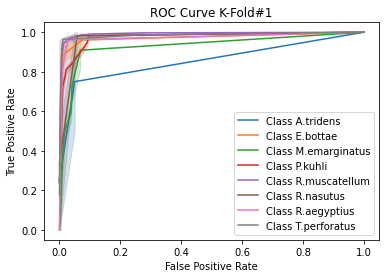

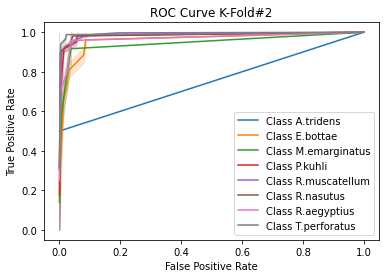

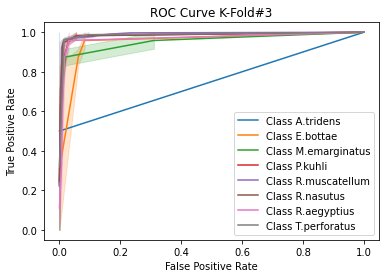

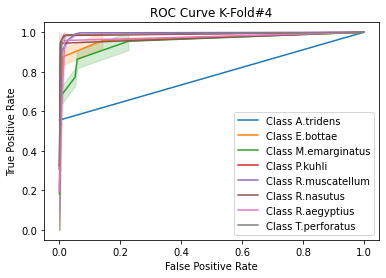

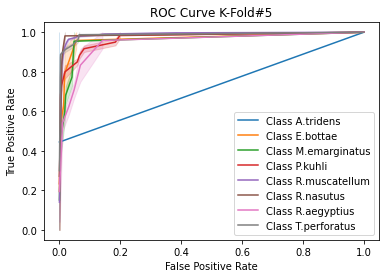

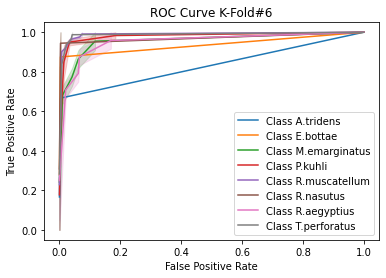

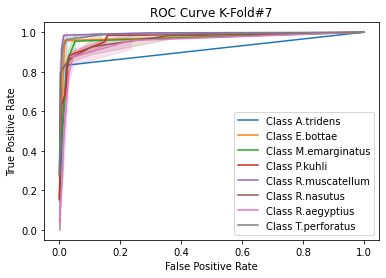

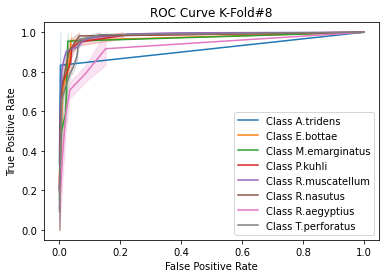

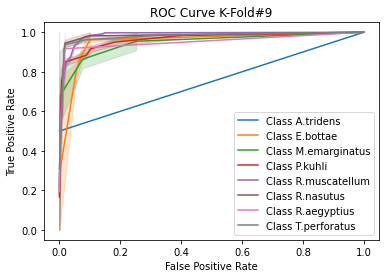

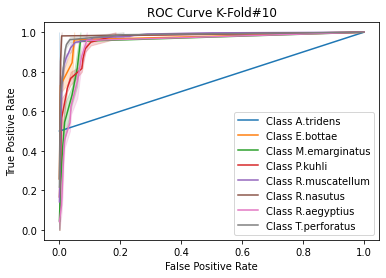

In [17]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

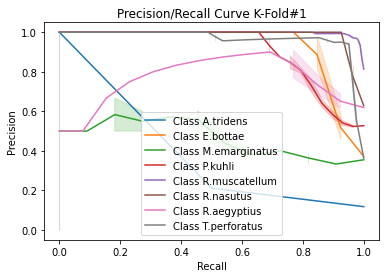

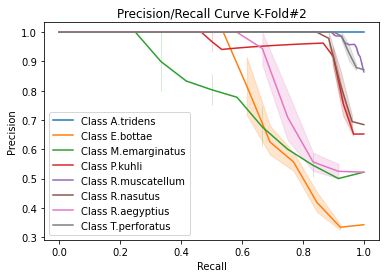

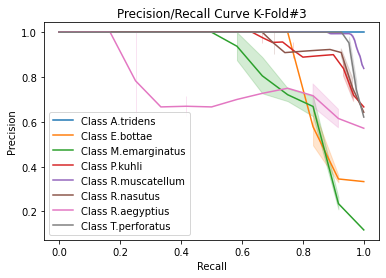

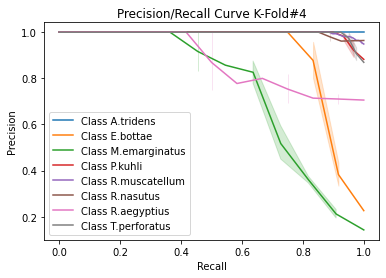

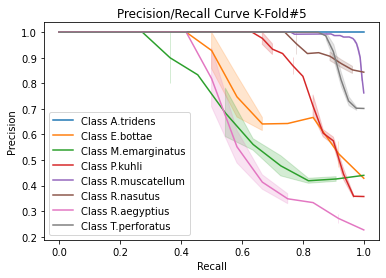

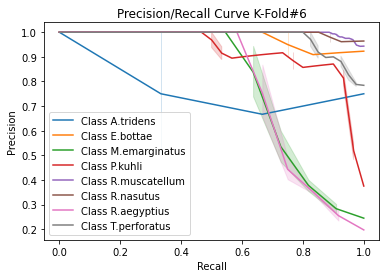

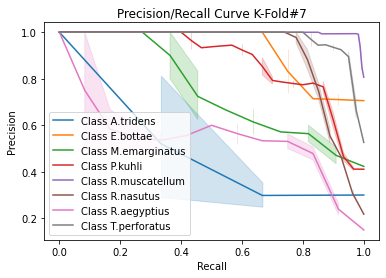

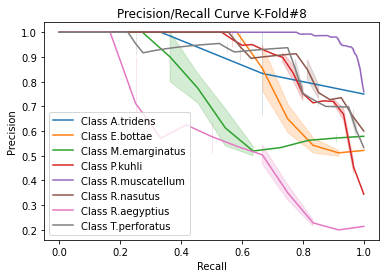

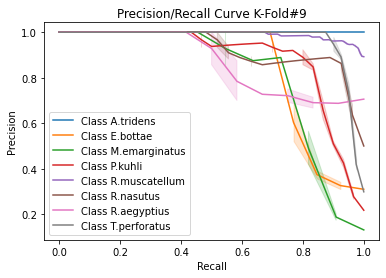

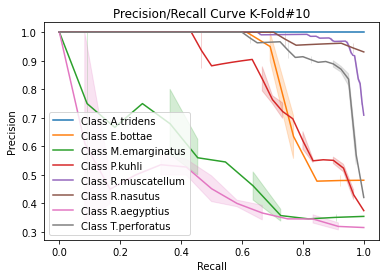

In [18]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  1   0   1   0   0   0   0   0]
 [  0   8   2   1   2   0   0   0]
 [  0   0   6   5   0   0   0   0]
 [  0   0   2  24   3   0   0   0]
 [  0   0   0   0 165   0   0   1]
 [  0   0   0   2   0  24   1   0]
 [  0   0   5   0   2   0   6   0]
 [  0   0   0   1   4   0   0  36]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0   8   0   0   2   2   1   0]
 [  0   0   8   1   0   0   3   0]
 [  0   0   3  20   1   4   1   1]
 [  0   0   0   0 155   0   7   4]
 [  0   0   0   0   1  24   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0   7   1   1   0   3   0]
 [  0   0   0  28   1   1   0   0]
 [  0   0   0   3 161   0   2   0]
 [  0   0   0   1   0  25   1   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   1   3   0   1  36]]


Confusion Matrix K-Fold #4

[[  2   0   1   0   0   0   0   0]
 [  

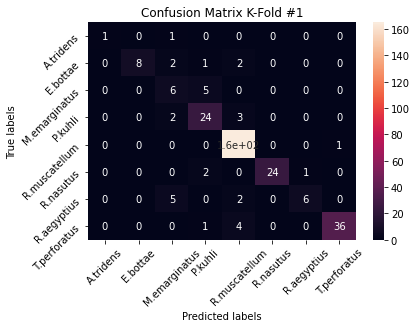

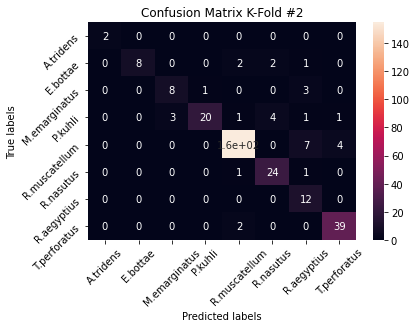

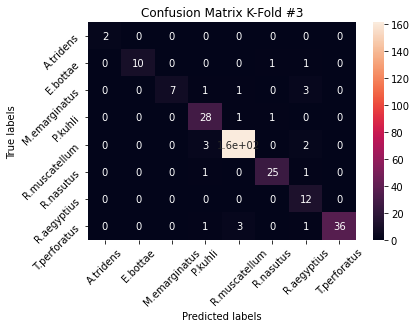

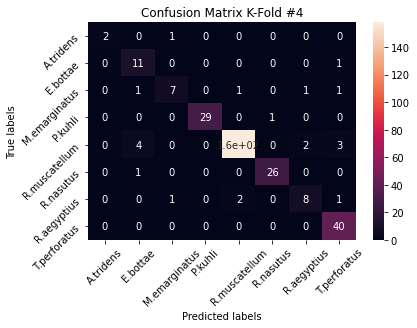

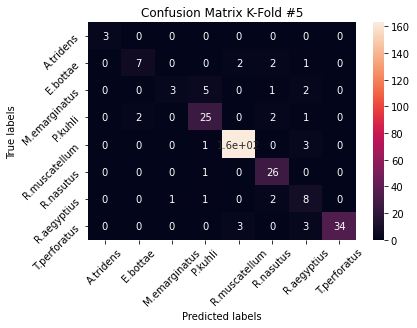

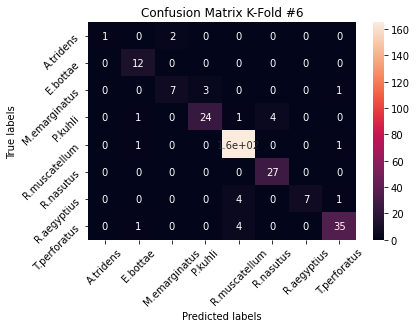

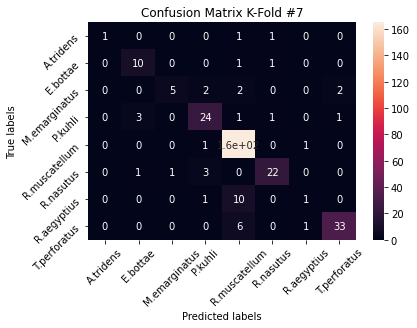

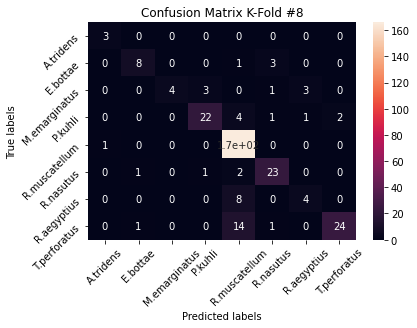

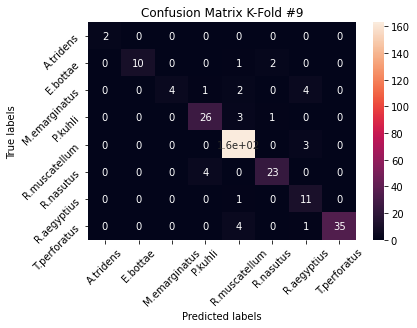

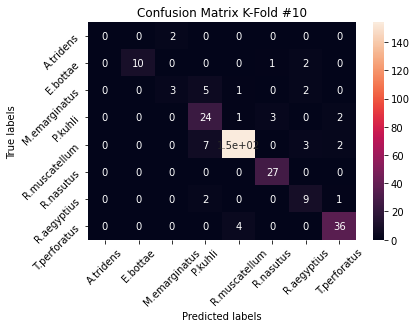

In [19]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  17    0    6    0    1    1    0    0]
 [   0   94    2    1    9   12    5    1]
 [   0    1   54   26    7    2   18    4]
 [   0    6    5  246   15   18    3    6]
 [   1    5    0   12 1615    0   21   11]
 [   0    3    1   12    3  247    3    0]
 [   0    0    7    4   27    2   78    3]
 [   0    2    0    2   44    1    6  348]]

average of all confuion matrices
 [[  1   0   0   0   0   0   0   0]
 [  0   9   0   0   0   1   0   0]
 [  0   0   5   2   0   0   1   0]
 [  0   0   0  24   1   1   0   0]
 [  0   0   0   1 161   0   2   1]
 [  0   0   0   1   0  24   0   0]
 [  0   0   0   0   2   0   7   0]
 [  0   0   0   0   4   0   0  34]]


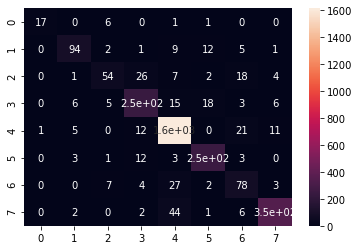

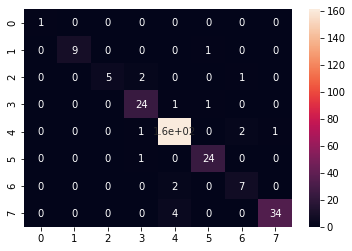

In [20]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.68 0.   0.24 0.   0.04 0.04 0.   0.  ]
 [0.   0.76 0.02 0.01 0.07 0.1  0.04 0.01]
 [0.   0.01 0.48 0.23 0.06 0.02 0.16 0.04]
 [0.   0.02 0.02 0.82 0.05 0.06 0.01 0.02]
 [0.   0.   0.   0.01 0.97 0.   0.01 0.01]
 [0.   0.01 0.   0.04 0.01 0.92 0.01 0.  ]
 [0.   0.   0.06 0.03 0.22 0.02 0.64 0.02]
 [0.   0.   0.   0.   0.11 0.   0.01 0.86]]


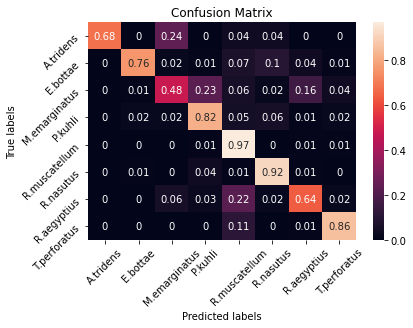

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V2 !!!!! K-Fold Training and Evaluation</h2>

In [23]:
 def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=24,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=136,kernel_size=(7,7),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=120,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(512)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.4)(lay)

    lay = Dense(256)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.3)(lay)

    lay = Dense(128)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.2)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [32]:

model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 56, 85, 24)        1824      
_________________________________________________________________
batch_normalization_182 (Bat (None, 56, 85, 24)        96        
_________________________________________________________________
activation_182 (Activation)  (None, 56, 85, 24)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 28, 43, 24)        0         
_________________________________________________________________
spatial_dropout2d_104 (Spati (None, 28, 43, 24)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 14, 22, 56)        336

In [24]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.2,
              verbose=2,
              callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/70
272/272 - 16s - loss: 1.5794 - accuracy: 0.5203 - val_loss: 1.7524 - val_accuracy: 0.5221
Epoch 2/70
272/272 - 2s - loss: 1.4826 - accuracy: 0.5396 - val_loss: 2.8803 - val_accuracy: 0.5221
Epoch 3/70
272/272 - 2s - loss: 1.4004 - accuracy: 0.5599 - val_loss: 1.7220 - val_accuracy: 0.5221
Epoch 4/70
272/272 - 2s - loss: 1.3249 - accuracy: 0.5695 - val_loss: 1.3693 - val_accuracy: 0.5607
Epoch 5/70
272/272 - 2s - loss: 1.2872 - accuracy: 0.5691 - val_loss: 2.0272 - val_accuracy: 0.5368
Epoch 6/70
272/272 - 2s - loss: 1.2260 - accuracy: 0.5829 - val_loss: 1.7249 - val_accuracy: 0.5221
Epoch 7/70
272/272 - 2s - loss: 1.1717 - accuracy: 0.5916 - val_loss: 1.1259 - val_accuracy: 0.5570
Epoch 8/70
272/272 - 2s - loss: 1.1067 - accuracy: 0.5925 - val_loss: 1.2120 - val_accuracy: 0.5478
Epoch 9/70
272/272 - 2s - loss: 1.0459 - accuracy: 0.6243 - val_loss: 0.9474 - val_accuracy: 0.6489
Epoch 10/70
272/272 - 2s - loss: 1.0095 - accuracy: 0.6450 - val_loss: 1.1846 - val_accuracy: 0.588

Epoch 13/70
272/272 - 3s - loss: 0.9346 - accuracy: 0.6809 - val_loss: 0.8955 - val_accuracy: 0.6875
Epoch 14/70
272/272 - 2s - loss: 0.8502 - accuracy: 0.7104 - val_loss: 0.9492 - val_accuracy: 0.6765
Epoch 15/70
272/272 - 2s - loss: 0.8295 - accuracy: 0.7238 - val_loss: 0.8134 - val_accuracy: 0.7077
Epoch 16/70
272/272 - 2s - loss: 0.7794 - accuracy: 0.7320 - val_loss: 0.9389 - val_accuracy: 0.6783
Epoch 17/70
272/272 - 2s - loss: 0.7203 - accuracy: 0.7574 - val_loss: 0.5988 - val_accuracy: 0.7757
Epoch 18/70
272/272 - 2s - loss: 0.7012 - accuracy: 0.7620 - val_loss: 0.7432 - val_accuracy: 0.7077
Epoch 19/70
272/272 - 2s - loss: 0.6890 - accuracy: 0.7721 - val_loss: 0.6541 - val_accuracy: 0.7757
Epoch 20/70
272/272 - 2s - loss: 0.6667 - accuracy: 0.7813 - val_loss: 0.7441 - val_accuracy: 0.7353
Epoch 21/70
272/272 - 2s - loss: 0.6228 - accuracy: 0.7942 - val_loss: 0.6215 - val_accuracy: 0.7923
Epoch 22/70
272/272 - 2s - loss: 0.5991 - accuracy: 0.8011 - val_loss: 0.6441 - val_accurac

Epoch 25/70
272/272 - 2s - loss: 0.4499 - accuracy: 0.8439 - val_loss: 0.8598 - val_accuracy: 0.7868
Epoch 26/70
272/272 - 2s - loss: 0.4662 - accuracy: 0.8476 - val_loss: 0.6840 - val_accuracy: 0.7721
Epoch 27/70
272/272 - 2s - loss: 0.4612 - accuracy: 0.8462 - val_loss: 0.3782 - val_accuracy: 0.8676
Epoch 28/70
272/272 - 2s - loss: 0.4548 - accuracy: 0.8582 - val_loss: 0.4065 - val_accuracy: 0.8548
Epoch 29/70
272/272 - 2s - loss: 0.4024 - accuracy: 0.8600 - val_loss: 0.5256 - val_accuracy: 0.8070
Epoch 30/70
272/272 - 3s - loss: 0.4359 - accuracy: 0.8577 - val_loss: 0.7038 - val_accuracy: 0.7390
Epoch 31/70
272/272 - 2s - loss: 0.4157 - accuracy: 0.8600 - val_loss: 0.4562 - val_accuracy: 0.8346
Epoch 32/70
272/272 - 2s - loss: 0.3952 - accuracy: 0.8702 - val_loss: 0.4409 - val_accuracy: 0.8493
Epoch 33/70
272/272 - 2s - loss: 0.4130 - accuracy: 0.8720 - val_loss: 0.4138 - val_accuracy: 0.8640
Epoch 34/70
272/272 - 2s - loss: 0.4134 - accuracy: 0.8674 - val_loss: 0.2775 - val_accurac

Epoch 37/70
272/272 - 3s - loss: 0.3706 - accuracy: 0.8785 - val_loss: 0.5098 - val_accuracy: 0.8180
Epoch 38/70
272/272 - 2s - loss: 0.3423 - accuracy: 0.8900 - val_loss: 0.5689 - val_accuracy: 0.8290
Epoch 39/70
272/272 - 2s - loss: 0.3583 - accuracy: 0.8840 - val_loss: 0.3322 - val_accuracy: 0.8860
Epoch 40/70
272/272 - 3s - loss: 0.3485 - accuracy: 0.8771 - val_loss: 0.7544 - val_accuracy: 0.7629
Epoch 41/70
272/272 - 2s - loss: 0.3678 - accuracy: 0.8863 - val_loss: 0.3786 - val_accuracy: 0.8750
Epoch 42/70
272/272 - 3s - loss: 0.3679 - accuracy: 0.8702 - val_loss: 0.3180 - val_accuracy: 0.9007
Epoch 43/70
272/272 - 2s - loss: 0.3076 - accuracy: 0.9001 - val_loss: 0.5058 - val_accuracy: 0.8327
Epoch 44/70
272/272 - 2s - loss: 0.2792 - accuracy: 0.9042 - val_loss: 0.4852 - val_accuracy: 0.8438
Epoch 45/70
272/272 - 2s - loss: 0.3397 - accuracy: 0.8863 - val_loss: 0.2950 - val_accuracy: 0.8971
Epoch 46/70
272/272 - 2s - loss: 0.2931 - accuracy: 0.8983 - val_loss: 0.5713 - val_accurac

Epoch 49/70
272/272 - 2s - loss: 0.2768 - accuracy: 0.9070 - val_loss: 0.2292 - val_accuracy: 0.9210
Epoch 50/70
272/272 - 2s - loss: 0.2813 - accuracy: 0.9038 - val_loss: 0.3699 - val_accuracy: 0.8493
Epoch 51/70
272/272 - 2s - loss: 0.2683 - accuracy: 0.9125 - val_loss: 0.2435 - val_accuracy: 0.9283
Epoch 52/70
272/272 - 2s - loss: 0.3014 - accuracy: 0.9042 - val_loss: 0.2679 - val_accuracy: 0.9044
Epoch 53/70
272/272 - 2s - loss: 0.2785 - accuracy: 0.9075 - val_loss: 0.2902 - val_accuracy: 0.8971
Epoch 54/70
272/272 - 3s - loss: 0.2637 - accuracy: 0.9075 - val_loss: 0.3877 - val_accuracy: 0.8787
Epoch 55/70
272/272 - 2s - loss: 0.3142 - accuracy: 0.9015 - val_loss: 0.3057 - val_accuracy: 0.9062
Epoch 56/70
272/272 - 2s - loss: 0.2609 - accuracy: 0.9111 - val_loss: 0.2909 - val_accuracy: 0.9173
Epoch 57/70
272/272 - 2s - loss: 0.3007 - accuracy: 0.9038 - val_loss: 0.5766 - val_accuracy: 0.8474
Epoch 58/70
272/272 - 2s - loss: 0.2730 - accuracy: 0.9194 - val_loss: 0.3113 - val_accurac

Epoch 61/70
272/272 - 2s - loss: 0.2420 - accuracy: 0.9222 - val_loss: 0.2373 - val_accuracy: 0.9228
Epoch 62/70
272/272 - 2s - loss: 0.1976 - accuracy: 0.9319 - val_loss: 0.2459 - val_accuracy: 0.9246
Epoch 63/70
272/272 - 2s - loss: 0.2462 - accuracy: 0.9231 - val_loss: 0.2333 - val_accuracy: 0.9154
Epoch 64/70
272/272 - 2s - loss: 0.2690 - accuracy: 0.9167 - val_loss: 0.2317 - val_accuracy: 0.9283
Epoch 65/70
272/272 - 3s - loss: 0.2294 - accuracy: 0.9144 - val_loss: 0.2981 - val_accuracy: 0.8879
Epoch 66/70
272/272 - 2s - loss: 0.1877 - accuracy: 0.9319 - val_loss: 0.2381 - val_accuracy: 0.9191
Epoch 67/70
272/272 - 2s - loss: 0.2141 - accuracy: 0.9296 - val_loss: 0.1752 - val_accuracy: 0.9393
Epoch 68/70
272/272 - 2s - loss: 0.2014 - accuracy: 0.9388 - val_loss: 0.2164 - val_accuracy: 0.9320
Epoch 69/70
272/272 - 2s - loss: 0.1825 - accuracy: 0.9383 - val_loss: 0.3826 - val_accuracy: 0.8585
Epoch 70/70
272/272 - 2s - loss: 0.1800 - accuracy: 0.9351 - val_loss: 0.3294 - val_accurac

Epoch 3/70
272/272 - 2s - loss: 1.4268 - accuracy: 0.5520 - val_loss: 4.3879 - val_accuracy: 0.5349
Epoch 4/70
272/272 - 2s - loss: 1.3608 - accuracy: 0.5603 - val_loss: 1.6043 - val_accuracy: 0.5349
Epoch 5/70
272/272 - 2s - loss: 1.3402 - accuracy: 0.5654 - val_loss: 1.3919 - val_accuracy: 0.5680
Epoch 6/70
272/272 - 2s - loss: 1.2534 - accuracy: 0.5801 - val_loss: 1.1746 - val_accuracy: 0.5717
Epoch 7/70
272/272 - 2s - loss: 1.1997 - accuracy: 0.5847 - val_loss: 1.1705 - val_accuracy: 0.6029
Epoch 8/70
272/272 - 2s - loss: 1.1528 - accuracy: 0.5981 - val_loss: 1.0266 - val_accuracy: 0.6103
Epoch 9/70
272/272 - 2s - loss: 1.0691 - accuracy: 0.6390 - val_loss: 0.9671 - val_accuracy: 0.6875
Epoch 10/70
272/272 - 2s - loss: 1.0111 - accuracy: 0.6496 - val_loss: 0.8379 - val_accuracy: 0.7445
Epoch 11/70
272/272 - 2s - loss: 0.9218 - accuracy: 0.6874 - val_loss: 0.9644 - val_accuracy: 0.6305
Epoch 12/70
272/272 - 2s - loss: 0.9213 - accuracy: 0.6851 - val_loss: 0.7388 - val_accuracy: 0.73

Epoch 15/70
272/272 - 2s - loss: 0.7306 - accuracy: 0.7464 - val_loss: 1.4208 - val_accuracy: 0.6415
Epoch 16/70
272/272 - 2s - loss: 0.7060 - accuracy: 0.7598 - val_loss: 0.8557 - val_accuracy: 0.7004
Epoch 17/70
272/272 - 2s - loss: 0.6697 - accuracy: 0.7736 - val_loss: 0.6873 - val_accuracy: 0.7665
Epoch 18/70
272/272 - 2s - loss: 0.6447 - accuracy: 0.7869 - val_loss: 1.5090 - val_accuracy: 0.6379
Epoch 19/70
272/272 - 2s - loss: 0.5984 - accuracy: 0.7929 - val_loss: 0.7565 - val_accuracy: 0.7371
Epoch 20/70
272/272 - 2s - loss: 0.5975 - accuracy: 0.7957 - val_loss: 0.9595 - val_accuracy: 0.6801
Epoch 21/70
272/272 - 2s - loss: 0.5992 - accuracy: 0.7994 - val_loss: 0.4564 - val_accuracy: 0.8401
Epoch 22/70
272/272 - 2s - loss: 0.5564 - accuracy: 0.8067 - val_loss: 0.5376 - val_accuracy: 0.8088
Epoch 23/70
272/272 - 2s - loss: 0.5199 - accuracy: 0.8178 - val_loss: 0.7126 - val_accuracy: 0.7518
Epoch 24/70
272/272 - 2s - loss: 0.5258 - accuracy: 0.8247 - val_loss: 0.9849 - val_accurac

Epoch 27/70
272/272 - 2s - loss: 0.4856 - accuracy: 0.8394 - val_loss: 0.7640 - val_accuracy: 0.7390
Epoch 28/70
272/272 - 2s - loss: 0.4741 - accuracy: 0.8472 - val_loss: 0.4339 - val_accuracy: 0.8438
Epoch 29/70
272/272 - 2s - loss: 0.4410 - accuracy: 0.8523 - val_loss: 0.9256 - val_accuracy: 0.6636
Epoch 30/70
272/272 - 2s - loss: 0.4699 - accuracy: 0.8514 - val_loss: 0.4233 - val_accuracy: 0.8640
Epoch 31/70
272/272 - 2s - loss: 0.4236 - accuracy: 0.8638 - val_loss: 0.3971 - val_accuracy: 0.8603
Epoch 32/70
272/272 - 2s - loss: 0.4126 - accuracy: 0.8596 - val_loss: 0.3696 - val_accuracy: 0.8676
Epoch 33/70
272/272 - 2s - loss: 0.4526 - accuracy: 0.8527 - val_loss: 0.3542 - val_accuracy: 0.8750
Epoch 34/70
272/272 - 2s - loss: 0.4090 - accuracy: 0.8652 - val_loss: 0.4743 - val_accuracy: 0.8290
Epoch 35/70
272/272 - 2s - loss: 0.4053 - accuracy: 0.8583 - val_loss: 0.4676 - val_accuracy: 0.8364
Epoch 36/70
272/272 - 2s - loss: 0.3823 - accuracy: 0.8744 - val_loss: 0.5124 - val_accurac

/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.9        0.90590243 0.74642524 0.84618085 0.96006847 0.83120294
 0.73826797 0.89653833]
precision sdev by class [0.3        0.10757339 0.20952685 0.12243592 0.01422799 0.09559704
 0.15267918 0.08679375]
macro precision mean 0.8530732788285855
macro precision sdev 0.05995217696784496
recall mean [0.76666667 0.71858974 0.70606061 0.8591954  0.96033836 0.87749288
 0.66025641 0.88573171]
recall sdev [0.36666667 0.19342517 0.16279244 0.09006427 0.02140268 0.08438052
 0.15691386 0.07012259]
macro recall mean 0.8042914716384942
macro recall sdev 0.07708721655956526
f1 mean [0.8        0.77638619 0.70483741 0.84304372 0.95999473 0.8501648
 0.67272419 0.88665662]
f1 sdev [0.33166248 0.13236585 0.14583181 0.06355744 0.01151049 0.07190074
 0.08150706 0.05443447]
macro f1 mean 0.811725955303978
macro f1 sdev 0.06647569316791228
accuracy mean 0.8999053926206242
accuracy sdev 0.026637831180386116


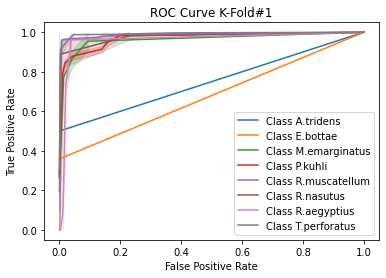

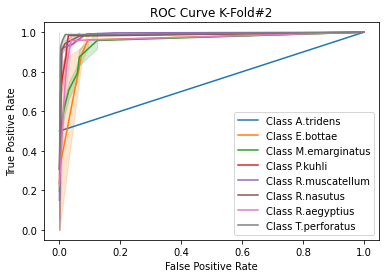

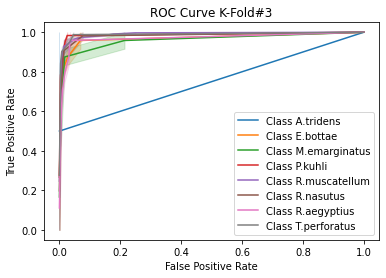

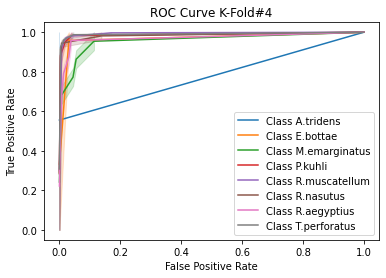

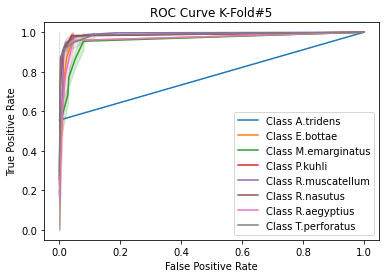

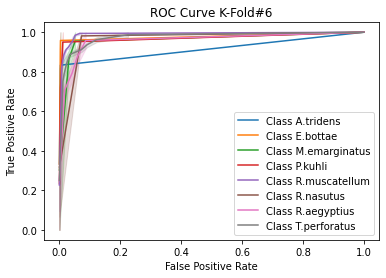

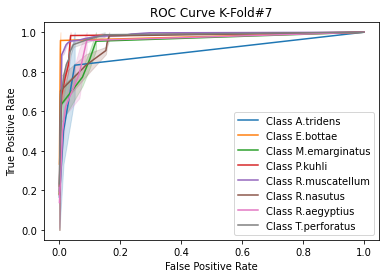

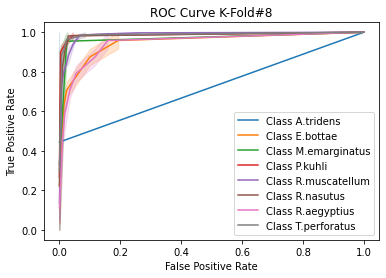

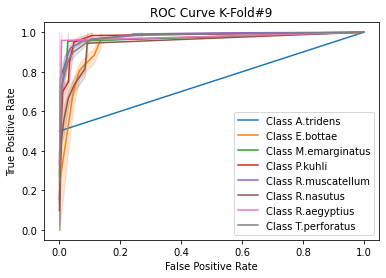

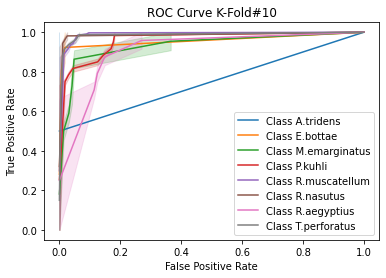

In [26]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

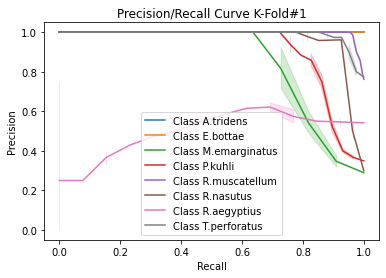

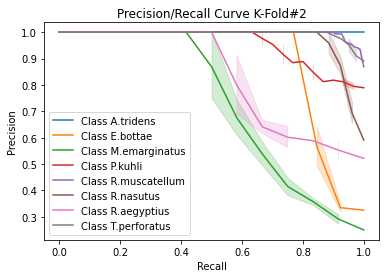

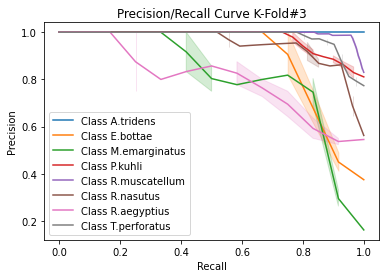

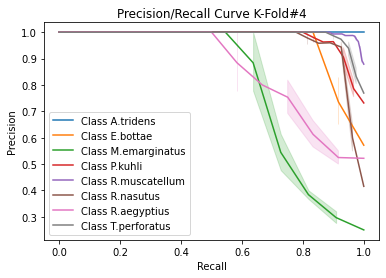

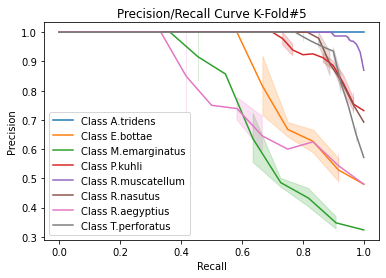

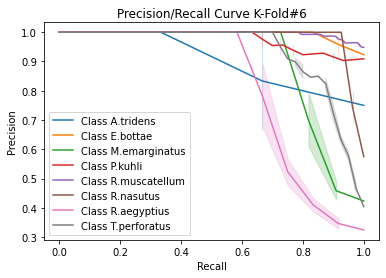

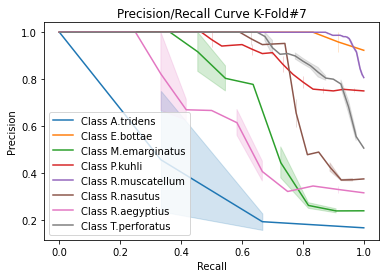

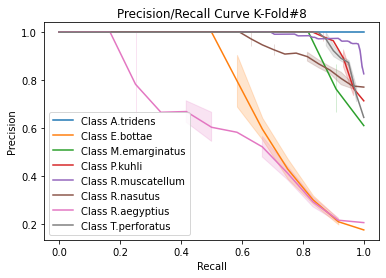

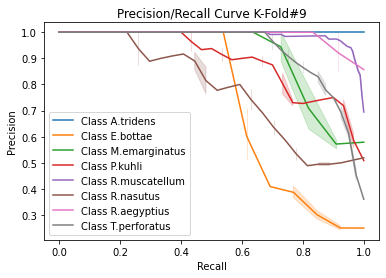

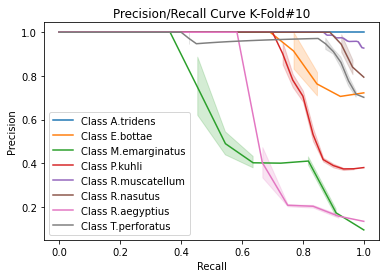

In [27]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   1   0   0]
 [  0   0   9   0   0   0   2   0]
 [  0   0   5  22   2   0   0   0]
 [  0   0   2   0 160   0   4   0]
 [  0   0   0   2   0  24   1   0]
 [  0   0   3   0   0   0  10   0]
 [  0   0   1   1   1   0   0  38]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   1   0   1   0]
 [  0   1   6   1   0   0   4   0]
 [  0   0   0  22   3   5   0   0]
 [  0   1   0   1 160   1   2   1]
 [  0   0   0   1   1  24   0   0]
 [  0   0   0   0   1   0  11   0]
 [  0   0   0   0   4   0   0  37]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0   9   0   0   0   2   1   0]
 [  0   0  10   0   2   0   0   0]
 [  0   0   1  29   0   0   0   0]
 [  0   0   0   3 160   0   2   1]
 [  0   1   0   3   1  22   0   0]
 [  0   0   2   0   0   0   9   1]
 [  0   1   0   0   4   0   0  36]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

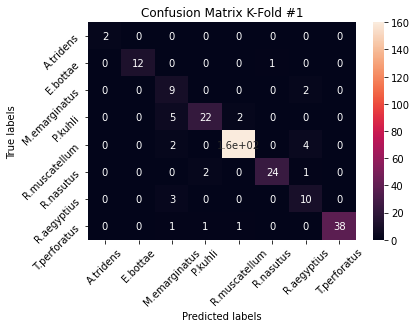

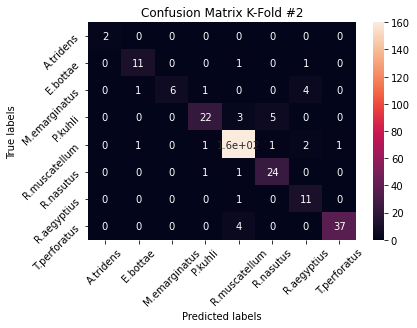

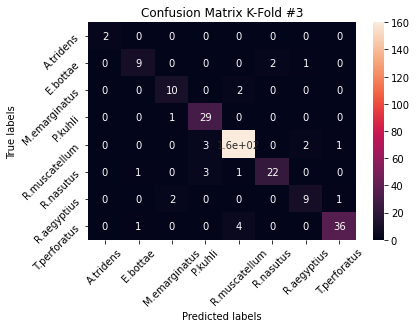

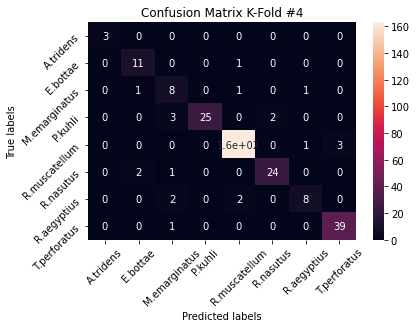

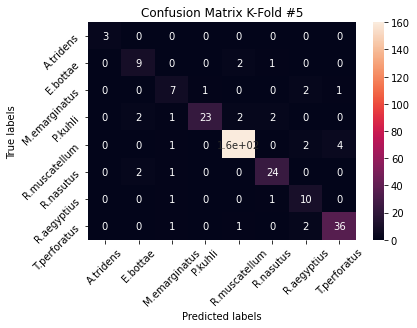

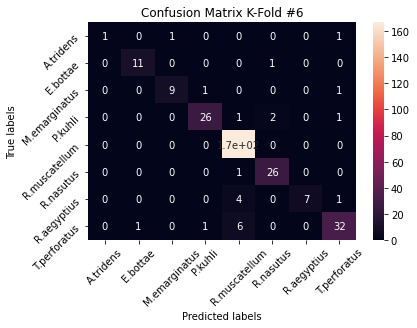

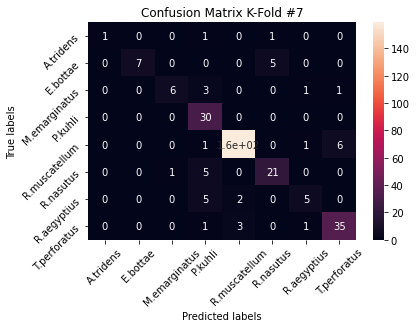

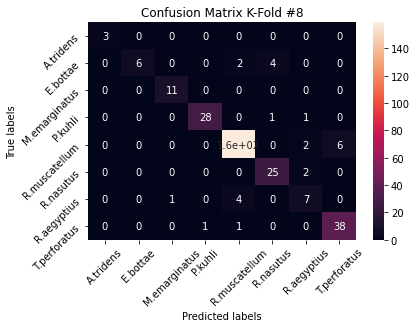

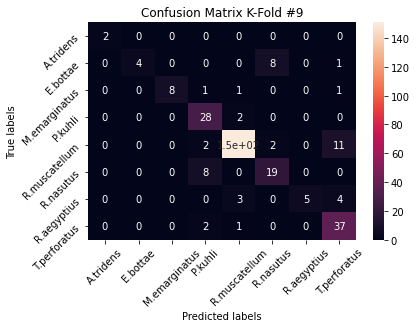

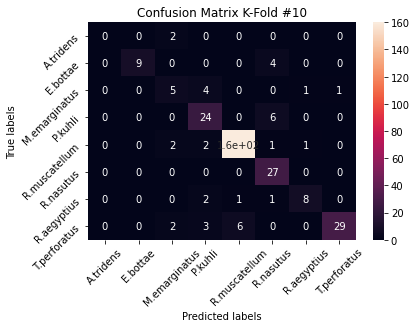

In [28]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  19    0    3    1    0    1    0    1]
 [   0   89    0    0    6   26    2    1]
 [   0    2   79   11    4    0   11    5]
 [   0    2   10  257   10   18    1    1]
 [   0    1    5    9 1599    4   15   32]
 [   0    5    3   19    3  236    3    0]
 [   0    0    9    7   17    2   80    6]
 [   0    2    5    9   27    0    3  357]]

average of all confuion matrices
 [[  1   0   0   0   0   0   0   0]
 [  0   8   0   0   0   2   0   0]
 [  0   0   7   1   0   0   1   0]
 [  0   0   1  25   1   1   0   0]
 [  0   0   0   0 159   0   1   3]
 [  0   0   0   1   0  23   0   0]
 [  0   0   0   0   1   0   8   0]
 [  0   0   0   0   2   0   0  35]]


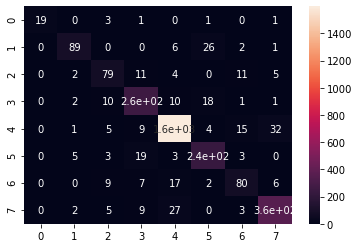

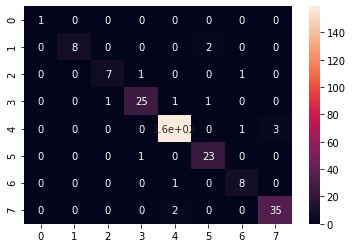

In [29]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.76 0.   0.12 0.04 0.   0.04 0.   0.04]
 [0.   0.72 0.   0.   0.05 0.21 0.02 0.01]
 [0.   0.02 0.71 0.1  0.04 0.   0.1  0.04]
 [0.   0.01 0.03 0.86 0.03 0.06 0.   0.  ]
 [0.   0.   0.   0.01 0.96 0.   0.01 0.02]
 [0.   0.02 0.01 0.07 0.01 0.88 0.01 0.  ]
 [0.   0.   0.07 0.06 0.14 0.02 0.66 0.05]
 [0.   0.   0.01 0.02 0.07 0.   0.01 0.89]]


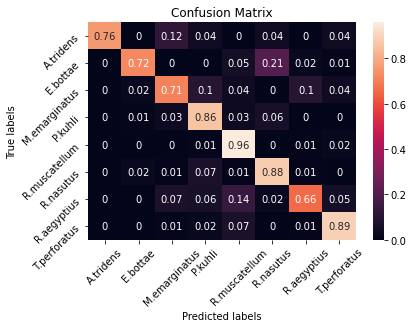

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V3 !!!!! K-Fold Training and Evaluation</h2>

In [37]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=176,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=48,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=144,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(144)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(96)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [38]:
model = build_current_model()
model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 56, 85, 176)       26048     
_________________________________________________________________
batch_normalization_203 (Bat (None, 56, 85, 176)       704       
_________________________________________________________________
activation_203 (Activation)  (None, 56, 85, 176)       0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 28, 43, 176)       0         
_________________________________________________________________
spatial_dropout2d_116 (Spati (None, 28, 43, 176)       0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 14, 22, 48)        211

In [39]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.2,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/70
272/272 - 21s - loss: 1.5877 - accuracy: 0.5193 - val_loss: 1.6556 - val_accuracy: 0.5221
Epoch 2/70
272/272 - 2s - loss: 1.4719 - accuracy: 0.5493 - val_loss: 1.5403 - val_accuracy: 0.5221
Epoch 3/70
272/272 - 3s - loss: 1.3735 - accuracy: 0.5557 - val_loss: 2.4449 - val_accuracy: 0.5221
Epoch 4/70
272/272 - 3s - loss: 1.3367 - accuracy: 0.5681 - val_loss: 1.8806 - val_accuracy: 0.5221
Epoch 5/70
272/272 - 3s - loss: 1.2653 - accuracy: 0.5806 - val_loss: 1.7100 - val_accuracy: 0.5312
Epoch 6/70
272/272 - 2s - loss: 1.2354 - accuracy: 0.5907 - val_loss: 1.7327 - val_accuracy: 0.5790
Epoch 7/70
272/272 - 2s - loss: 1.1653 - accuracy: 0.6137 - val_loss: 1.3746 - val_accuracy: 0.5349
Epoch 8/70
272/272 - 3s - loss: 1.1060 - accuracy: 0.6179 - val_loss: 1.8076 - val_accuracy: 0.5257
Epoch 9/70
272/272 - 3s - loss: 1.0102 - accuracy: 0.6459 - val_loss: 1.2949 - val_accuracy: 0.5294
Epoch 10/70
272/272 - 3s - loss: 0.9819 - accuracy: 0.6552 - val_loss: 1.8729 - val_accuracy: 0.525

Epoch 13/70
272/272 - 2s - loss: 0.7903 - accuracy: 0.7164 - val_loss: 1.4834 - val_accuracy: 0.5938
Epoch 14/70
272/272 - 3s - loss: 0.7267 - accuracy: 0.7505 - val_loss: 1.2735 - val_accuracy: 0.6232
Epoch 15/70
272/272 - 3s - loss: 0.7090 - accuracy: 0.7615 - val_loss: 0.7507 - val_accuracy: 0.7353
Epoch 16/70
272/272 - 2s - loss: 0.6869 - accuracy: 0.7675 - val_loss: 0.7838 - val_accuracy: 0.6875
Epoch 17/70
272/272 - 3s - loss: 0.6424 - accuracy: 0.7988 - val_loss: 0.5645 - val_accuracy: 0.8051
Epoch 18/70
272/272 - 2s - loss: 0.6343 - accuracy: 0.7836 - val_loss: 0.5672 - val_accuracy: 0.7812
Epoch 19/70
272/272 - 3s - loss: 0.5974 - accuracy: 0.7993 - val_loss: 0.5108 - val_accuracy: 0.8143
Epoch 20/70
272/272 - 3s - loss: 0.6251 - accuracy: 0.7947 - val_loss: 0.5682 - val_accuracy: 0.7868
Epoch 21/70
272/272 - 2s - loss: 0.5904 - accuracy: 0.8062 - val_loss: 0.7682 - val_accuracy: 0.7261
Epoch 22/70
272/272 - 2s - loss: 0.5402 - accuracy: 0.8241 - val_loss: 0.6490 - val_accurac

Epoch 25/70
272/272 - 2s - loss: 0.4990 - accuracy: 0.8435 - val_loss: 0.4915 - val_accuracy: 0.8272
Epoch 26/70
272/272 - 2s - loss: 0.4836 - accuracy: 0.8389 - val_loss: 0.7048 - val_accuracy: 0.7721
Epoch 27/70
272/272 - 3s - loss: 0.4394 - accuracy: 0.8559 - val_loss: 0.6842 - val_accuracy: 0.7390
Epoch 28/70
272/272 - 3s - loss: 0.4332 - accuracy: 0.8541 - val_loss: 0.4336 - val_accuracy: 0.8217
Epoch 29/70
272/272 - 3s - loss: 0.4619 - accuracy: 0.8504 - val_loss: 0.4812 - val_accuracy: 0.8290
Epoch 30/70
272/272 - 3s - loss: 0.4502 - accuracy: 0.8564 - val_loss: 0.7276 - val_accuracy: 0.6893
Epoch 31/70
272/272 - 3s - loss: 0.3980 - accuracy: 0.8637 - val_loss: 0.4859 - val_accuracy: 0.8254
Epoch 32/70
272/272 - 2s - loss: 0.4122 - accuracy: 0.8591 - val_loss: 0.3130 - val_accuracy: 0.8860
Epoch 33/70
272/272 - 3s - loss: 0.3938 - accuracy: 0.8665 - val_loss: 0.3950 - val_accuracy: 0.8548
Epoch 34/70
272/272 - 3s - loss: 0.3963 - accuracy: 0.8688 - val_loss: 0.5048 - val_accurac

Epoch 37/70
272/272 - 2s - loss: 0.3881 - accuracy: 0.8748 - val_loss: 0.4329 - val_accuracy: 0.8566
Epoch 38/70
272/272 - 3s - loss: 0.3867 - accuracy: 0.8614 - val_loss: 0.3696 - val_accuracy: 0.8824
Epoch 39/70
272/272 - 3s - loss: 0.3740 - accuracy: 0.8711 - val_loss: 0.3232 - val_accuracy: 0.8768
Epoch 40/70
272/272 - 3s - loss: 0.3723 - accuracy: 0.8665 - val_loss: 0.3585 - val_accuracy: 0.8860
Epoch 41/70
272/272 - 3s - loss: 0.3953 - accuracy: 0.8683 - val_loss: 0.4415 - val_accuracy: 0.8456
Epoch 42/70
272/272 - 3s - loss: 0.3640 - accuracy: 0.8849 - val_loss: 0.4766 - val_accuracy: 0.8327
Epoch 43/70
272/272 - 3s - loss: 0.3583 - accuracy: 0.8817 - val_loss: 0.3349 - val_accuracy: 0.8842
Epoch 44/70
272/272 - 2s - loss: 0.3668 - accuracy: 0.8798 - val_loss: 0.5417 - val_accuracy: 0.8162
Epoch 45/70
272/272 - 2s - loss: 0.3342 - accuracy: 0.8877 - val_loss: 0.3980 - val_accuracy: 0.8456
Epoch 46/70
272/272 - 2s - loss: 0.3553 - accuracy: 0.8785 - val_loss: 0.3481 - val_accurac

Epoch 49/70
272/272 - 2s - loss: 0.2969 - accuracy: 0.8973 - val_loss: 0.2946 - val_accuracy: 0.9044
Epoch 50/70
272/272 - 3s - loss: 0.3168 - accuracy: 0.8950 - val_loss: 0.2833 - val_accuracy: 0.9062
Epoch 51/70
272/272 - 2s - loss: 0.2688 - accuracy: 0.9065 - val_loss: 0.3452 - val_accuracy: 0.8915
Epoch 52/70
272/272 - 3s - loss: 0.2683 - accuracy: 0.9102 - val_loss: 0.2685 - val_accuracy: 0.9136
Epoch 53/70
272/272 - 3s - loss: 0.2973 - accuracy: 0.8996 - val_loss: 0.4141 - val_accuracy: 0.8419
Epoch 54/70
272/272 - 2s - loss: 0.2628 - accuracy: 0.9180 - val_loss: 0.2690 - val_accuracy: 0.9062
Epoch 55/70
272/272 - 3s - loss: 0.3005 - accuracy: 0.8996 - val_loss: 0.3834 - val_accuracy: 0.8658
Epoch 56/70
272/272 - 3s - loss: 0.2405 - accuracy: 0.9171 - val_loss: 0.3065 - val_accuracy: 0.8971
Epoch 57/70
272/272 - 3s - loss: 0.2658 - accuracy: 0.9079 - val_loss: 0.3114 - val_accuracy: 0.8860
Epoch 58/70
272/272 - 3s - loss: 0.2726 - accuracy: 0.9144 - val_loss: 0.4111 - val_accurac

Epoch 61/70
272/272 - 3s - loss: 0.2263 - accuracy: 0.9190 - val_loss: 0.4328 - val_accuracy: 0.8548
Epoch 62/70
272/272 - 2s - loss: 0.2903 - accuracy: 0.9038 - val_loss: 0.3223 - val_accuracy: 0.8824
Epoch 63/70
272/272 - 3s - loss: 0.2586 - accuracy: 0.9098 - val_loss: 0.3587 - val_accuracy: 0.8676
Epoch 64/70
272/272 - 2s - loss: 0.2632 - accuracy: 0.9088 - val_loss: 0.3577 - val_accuracy: 0.8640
Epoch 65/70
272/272 - 2s - loss: 0.2888 - accuracy: 0.9047 - val_loss: 0.3450 - val_accuracy: 0.8787
Epoch 66/70
272/272 - 3s - loss: 0.2311 - accuracy: 0.9245 - val_loss: 0.3067 - val_accuracy: 0.8989
Epoch 67/70
272/272 - 3s - loss: 0.2481 - accuracy: 0.9185 - val_loss: 0.3201 - val_accuracy: 0.8915
Epoch 68/70
272/272 - 3s - loss: 0.2798 - accuracy: 0.9075 - val_loss: 0.3422 - val_accuracy: 0.8787
Epoch 69/70
272/272 - 3s - loss: 0.2466 - accuracy: 0.9121 - val_loss: 0.3272 - val_accuracy: 0.8915
Epoch 70/70
272/272 - 3s - loss: 0.2456 - accuracy: 0.9180 - val_loss: 0.2678 - val_accurac

Epoch 3/70
272/272 - 3s - loss: 1.3341 - accuracy: 0.5631 - val_loss: 1.3058 - val_accuracy: 0.5551
Epoch 4/70
272/272 - 3s - loss: 1.3155 - accuracy: 0.5732 - val_loss: 1.2285 - val_accuracy: 0.5441
Epoch 5/70
272/272 - 3s - loss: 1.2720 - accuracy: 0.5764 - val_loss: 1.2362 - val_accuracy: 0.5809
Epoch 6/70
272/272 - 3s - loss: 1.2284 - accuracy: 0.5902 - val_loss: 1.2288 - val_accuracy: 0.5919
Epoch 7/70
272/272 - 3s - loss: 1.1607 - accuracy: 0.6004 - val_loss: 1.1445 - val_accuracy: 0.5827
Epoch 8/70
272/272 - 3s - loss: 1.1233 - accuracy: 0.6146 - val_loss: 1.3198 - val_accuracy: 0.5349
Epoch 9/70
272/272 - 3s - loss: 1.0292 - accuracy: 0.6593 - val_loss: 1.1994 - val_accuracy: 0.6048
Epoch 10/70
272/272 - 2s - loss: 0.9488 - accuracy: 0.6883 - val_loss: 1.0126 - val_accuracy: 0.6507
Epoch 11/70
272/272 - 3s - loss: 0.8678 - accuracy: 0.7086 - val_loss: 0.7653 - val_accuracy: 0.7169
Epoch 12/70
272/272 - 3s - loss: 0.8217 - accuracy: 0.7132 - val_loss: 0.7653 - val_accuracy: 0.76

Epoch 15/70
272/272 - 3s - loss: 0.6918 - accuracy: 0.7625 - val_loss: 0.6854 - val_accuracy: 0.7647
Epoch 16/70
272/272 - 3s - loss: 0.6452 - accuracy: 0.7925 - val_loss: 0.7663 - val_accuracy: 0.7261
Epoch 17/70
272/272 - 3s - loss: 0.6586 - accuracy: 0.7796 - val_loss: 0.7070 - val_accuracy: 0.7463
Epoch 18/70
272/272 - 3s - loss: 0.5833 - accuracy: 0.8086 - val_loss: 0.6832 - val_accuracy: 0.7482
Epoch 19/70
272/272 - 3s - loss: 0.5911 - accuracy: 0.8049 - val_loss: 0.9475 - val_accuracy: 0.7096
Epoch 20/70
272/272 - 3s - loss: 0.5593 - accuracy: 0.8159 - val_loss: 1.4157 - val_accuracy: 0.6066
Epoch 21/70
272/272 - 3s - loss: 0.5428 - accuracy: 0.8219 - val_loss: 0.4735 - val_accuracy: 0.8364
Epoch 22/70
272/272 - 3s - loss: 0.5123 - accuracy: 0.8339 - val_loss: 0.7317 - val_accuracy: 0.7390
Epoch 23/70
272/272 - 3s - loss: 0.4768 - accuracy: 0.8376 - val_loss: 0.6044 - val_accuracy: 0.7776
Epoch 24/70
272/272 - 3s - loss: 0.5027 - accuracy: 0.8325 - val_loss: 0.6709 - val_accurac

Epoch 27/70
272/272 - 2s - loss: 0.4865 - accuracy: 0.8274 - val_loss: 0.5012 - val_accuracy: 0.8107
Epoch 28/70
272/272 - 2s - loss: 0.4606 - accuracy: 0.8537 - val_loss: 0.5211 - val_accuracy: 0.8070
Epoch 29/70
272/272 - 3s - loss: 0.4472 - accuracy: 0.8514 - val_loss: 0.4317 - val_accuracy: 0.8603
Epoch 30/70
272/272 - 3s - loss: 0.4412 - accuracy: 0.8624 - val_loss: 0.5528 - val_accuracy: 0.8070
Epoch 31/70
272/272 - 3s - loss: 0.4218 - accuracy: 0.8629 - val_loss: 0.5462 - val_accuracy: 0.8162
Epoch 32/70
272/272 - 3s - loss: 0.4375 - accuracy: 0.8693 - val_loss: 0.3906 - val_accuracy: 0.8732
Epoch 33/70
272/272 - 3s - loss: 0.3929 - accuracy: 0.8707 - val_loss: 0.3464 - val_accuracy: 0.8842
Epoch 34/70
272/272 - 2s - loss: 0.4535 - accuracy: 0.8578 - val_loss: 0.5001 - val_accuracy: 0.8217
Epoch 35/70
272/272 - 2s - loss: 0.3737 - accuracy: 0.8744 - val_loss: 0.7046 - val_accuracy: 0.7445
Epoch 36/70
272/272 - 3s - loss: 0.3838 - accuracy: 0.8831 - val_loss: 0.4186 - val_accurac

In [40]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.95       0.92413919 0.80333333 0.88838308 0.95967138 0.91071815
 0.60679272 0.9124783 ]
precision sdev by class [0.15       0.08171757 0.10946142 0.07663666 0.02161008 0.06689604
 0.12700072 0.07087943]
macro precision mean 0.8694395197915004
macro precision sdev 0.020975900571675452
recall mean [0.86666667 0.80833333 0.67878788 0.89287356 0.97418296 0.88091168
 0.77435897 0.85847561]
recall sdev [0.22110832 0.16260965 0.14873201 0.07136589 0.0136892  0.05476907
 0.25465424 0.0502429 ]
macro recall mean 0.8418238333019328
macro recall sdev 0.029331014985913013
f1 mean [0.88714286 0.8477352  0.72540795 0.88590243 0.96668724 0.89438553
 0.66068458 0.88216367]
f1 sdev [0.18609302 0.08761711 0.10043509 0.03930445 0.0124497  0.05143196
 0.18934888 0.04040312]
macro f1 mean 0.8437636806802047
macro f1 sdev 0.02733618082325393
accuracy mean 0.9151800840465556
accuracy sdev 0.014127222134127457


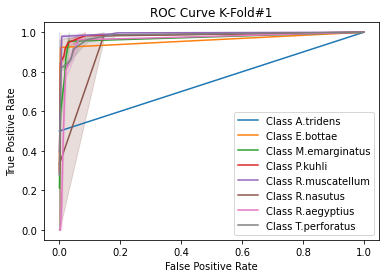

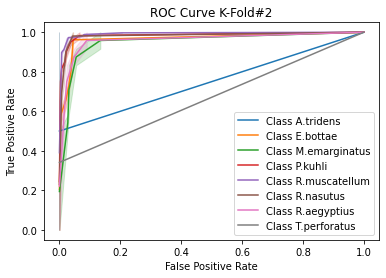

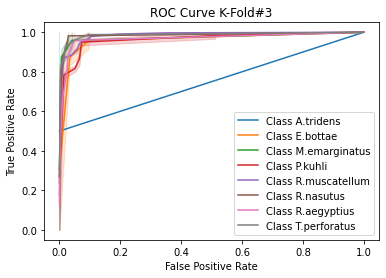

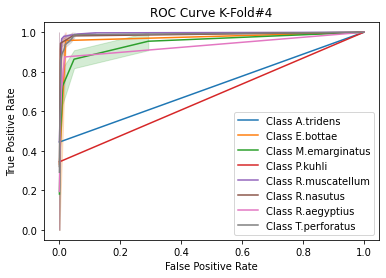

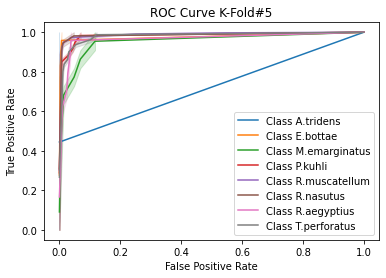

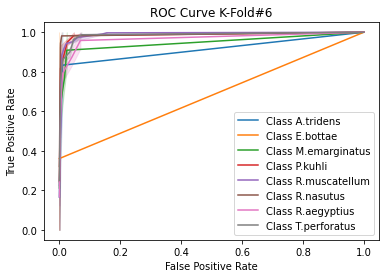

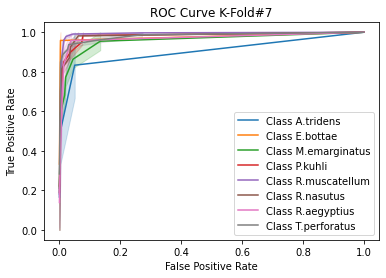

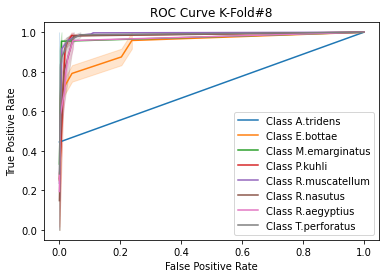

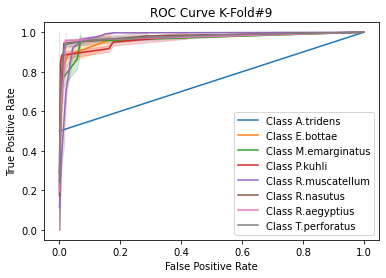

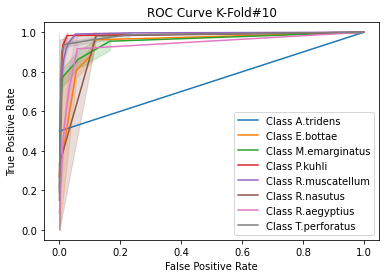

In [41]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

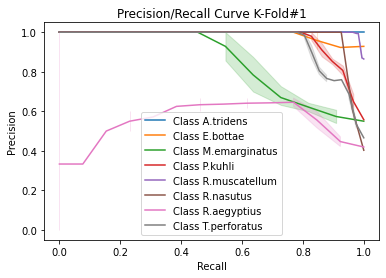

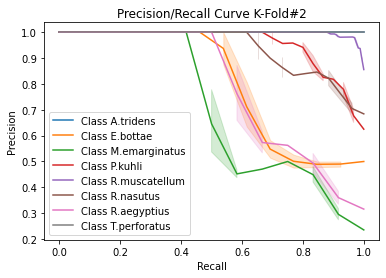

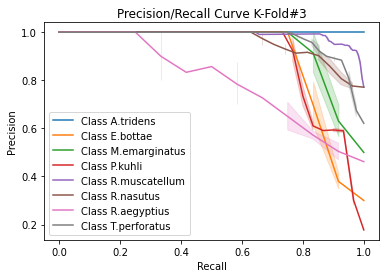

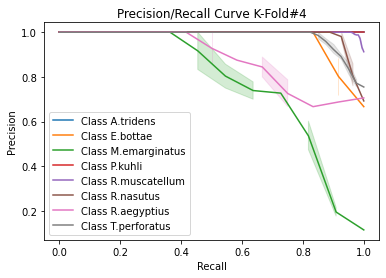

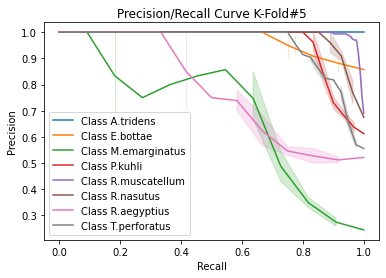

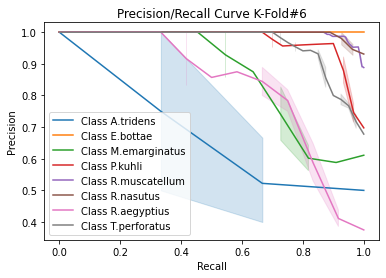

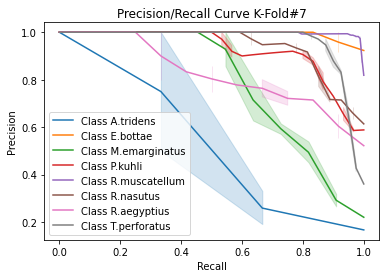

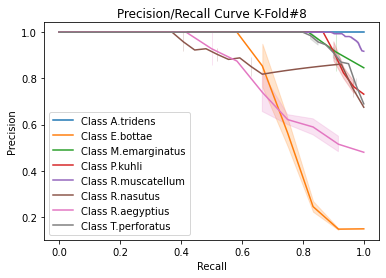

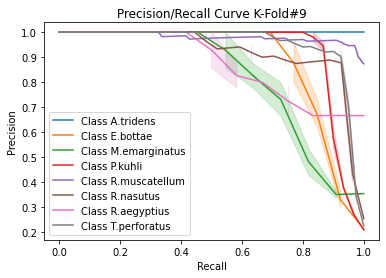

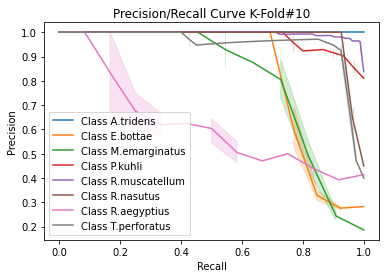

In [42]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0   7   1   1   0   0   2]
 [  0   0   0  25   3   0   1   0]
 [  0   1   0   0 164   0   0   1]
 [  0   0   0   1   1  24   1   0]
 [  0   0   1   0   4   0   1   7]
 [  0   0   0   0   6   0   0  35]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0   7   0   0   2   3   1   0]
 [  0   0   6   3   0   0   3   0]
 [  0   0   1  28   0   1   0   0]
 [  0   0   0   1 161   2   2   0]
 [  0   0   0   4   0  22   0   0]
 [  0   0   0   2   0   0  10   0]
 [  0   0   1   0   3   0   1  36]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0  10   0   0   0   1   1]
 [  0   0   0  23   6   1   0   0]
 [  0   1   0   0 159   0   3   3]
 [  0   1   0   0   1  23   2   0]
 [  0   0   0   0   1   0  10   1]
 [  0   0   0   0   4   0   1  36]]


Confusion Matrix K-Fold #4

[[  2   0   0   0   0   0   1   0]
 [  

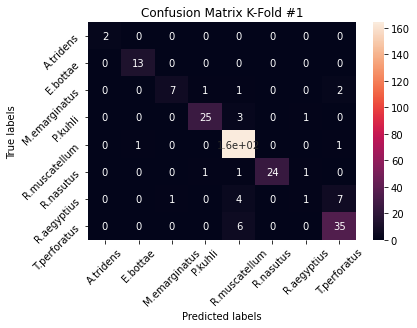

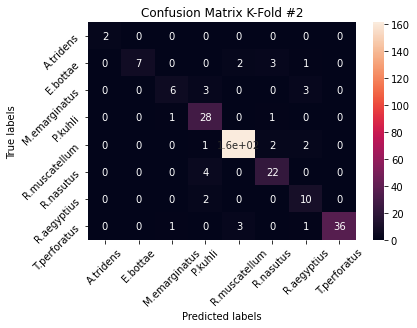

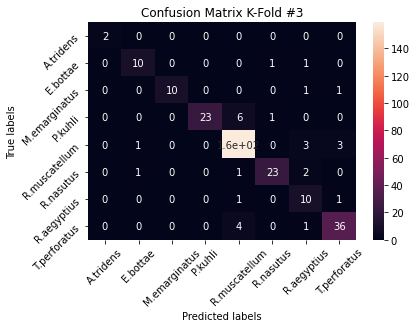

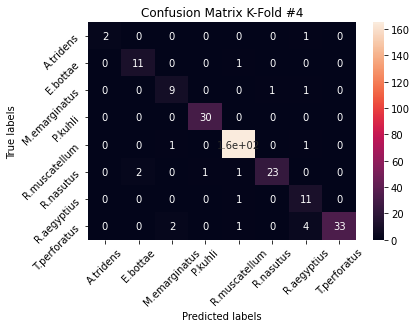

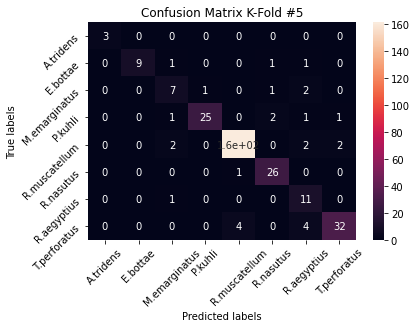

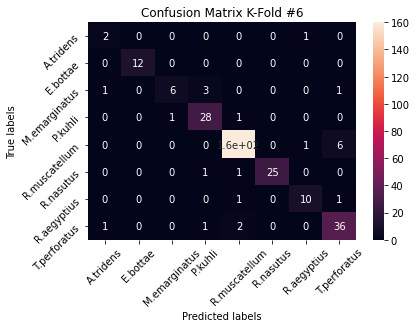

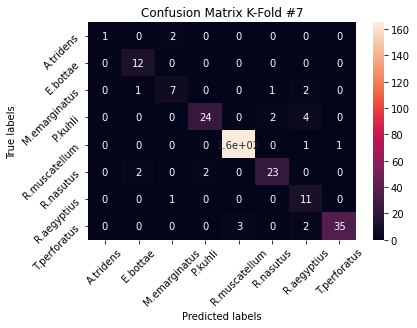

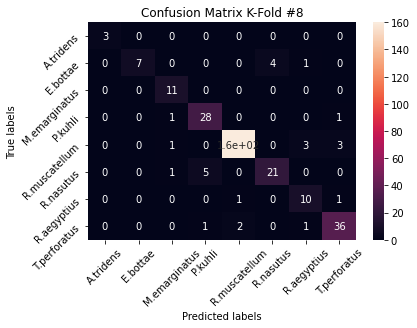

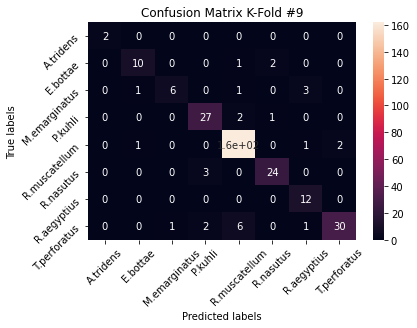

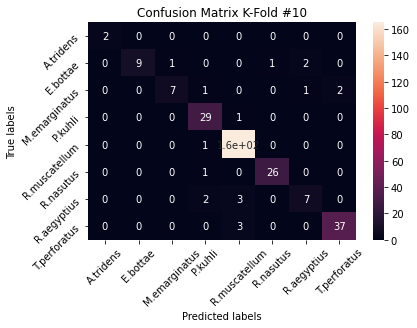

In [43]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  21    0    2    0    0    0    2    0]
 [   0  100    2    0    4   12    6    0]
 [   1    2   76    9    2    3   13    6]
 [   0    0    4  267   13    7    6    2]
 [   0    3    4    2 1622    2   14   18]
 [   0    5    1   18    5  237    3    0]
 [   0    0    3    4   11    0   93   10]
 [   1    0    4    4   34    0   14  346]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   0   0]
 [  0   0   7   0   0   0   1   0]
 [  0   0   0  26   1   0   0   0]
 [  0   0   0   0 162   0   1   1]
 [  0   0   0   1   0  23   0   0]
 [  0   0   0   0   1   0   9   1]
 [  0   0   0   0   3   0   1  34]]


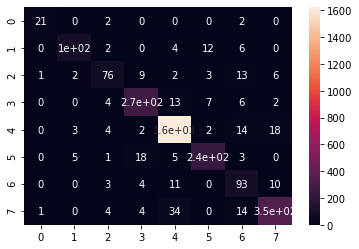

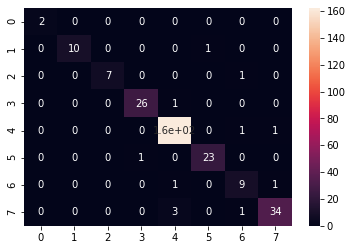

In [44]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.84 0.   0.08 0.   0.   0.   0.08 0.  ]
 [0.   0.81 0.02 0.   0.03 0.1  0.05 0.  ]
 [0.01 0.02 0.68 0.08 0.02 0.03 0.12 0.05]
 [0.   0.   0.01 0.89 0.04 0.02 0.02 0.01]
 [0.   0.   0.   0.   0.97 0.   0.01 0.01]
 [0.   0.02 0.   0.07 0.02 0.88 0.01 0.  ]
 [0.   0.   0.02 0.03 0.09 0.   0.77 0.08]
 [0.   0.   0.01 0.01 0.08 0.   0.03 0.86]]


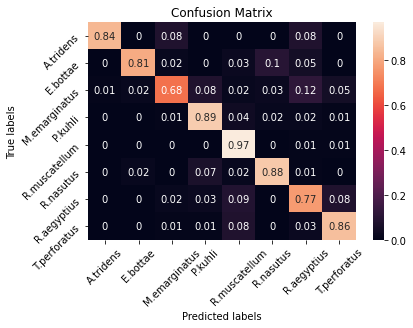

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V4 !!!!! K-Fold Training and Evaluation</h2>

In [50]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=160,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=112,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=80,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(256)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(448)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(352)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [51]:
model = build_current_model()
model.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 56, 85, 160)       23680     
_________________________________________________________________
batch_normalization_294 (Bat (None, 56, 85, 160)       640       
_________________________________________________________________
activation_294 (Activation)  (None, 56, 85, 160)       0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 28, 43, 160)       0         
_________________________________________________________________
spatial_dropout2d_168 (Spati (None, 28, 43, 160)       0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 14, 22, 112)       448

In [52]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.2,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/70
272/272 - 21s - loss: 1.6583 - accuracy: 0.5064 - val_loss: 1.5069 - val_accuracy: 0.5221
Epoch 2/70
272/272 - 2s - loss: 1.4396 - accuracy: 0.5502 - val_loss: 1.5398 - val_accuracy: 0.5515
Epoch 3/70
272/272 - 2s - loss: 1.3836 - accuracy: 0.5622 - val_loss: 1.2857 - val_accuracy: 0.5368
Epoch 4/70
272/272 - 3s - loss: 1.2577 - accuracy: 0.5746 - val_loss: 2.3522 - val_accuracy: 0.5221
Epoch 5/70
272/272 - 3s - loss: 1.2374 - accuracy: 0.5866 - val_loss: 1.8205 - val_accuracy: 0.5515
Epoch 6/70
272/272 - 3s - loss: 1.1843 - accuracy: 0.5912 - val_loss: 1.3112 - val_accuracy: 0.5882
Epoch 7/70
272/272 - 3s - loss: 1.0675 - accuracy: 0.6285 - val_loss: 1.2006 - val_accuracy: 0.6434
Epoch 8/70
272/272 - 3s - loss: 1.0017 - accuracy: 0.6570 - val_loss: 2.1091 - val_accuracy: 0.3805
Epoch 9/70
272/272 - 2s - loss: 1.0144 - accuracy: 0.6570 - val_loss: 1.1259 - val_accuracy: 0.6471
Epoch 10/70
272/272 - 2s - loss: 0.9220 - accuracy: 0.6717 - val_loss: 0.8832 - val_accuracy: 0.687

Epoch 13/70
272/272 - 3s - loss: 0.8285 - accuracy: 0.7136 - val_loss: 0.8511 - val_accuracy: 0.6728
Epoch 14/70
272/272 - 3s - loss: 0.8080 - accuracy: 0.7201 - val_loss: 0.7466 - val_accuracy: 0.7629
Epoch 15/70
272/272 - 3s - loss: 0.7523 - accuracy: 0.7422 - val_loss: 0.8182 - val_accuracy: 0.7316
Epoch 16/70
272/272 - 3s - loss: 0.7244 - accuracy: 0.7615 - val_loss: 1.0385 - val_accuracy: 0.6287
Epoch 17/70
272/272 - 3s - loss: 0.6981 - accuracy: 0.7592 - val_loss: 1.1541 - val_accuracy: 0.6103
Epoch 18/70
272/272 - 3s - loss: 0.6753 - accuracy: 0.7790 - val_loss: 0.8069 - val_accuracy: 0.7390
Epoch 19/70
272/272 - 3s - loss: 0.6409 - accuracy: 0.7951 - val_loss: 0.5672 - val_accuracy: 0.7960
Epoch 20/70
272/272 - 3s - loss: 0.6102 - accuracy: 0.7974 - val_loss: 0.5638 - val_accuracy: 0.8051
Epoch 21/70
272/272 - 2s - loss: 0.5455 - accuracy: 0.8214 - val_loss: 0.6637 - val_accuracy: 0.7390
Epoch 22/70
272/272 - 3s - loss: 0.5177 - accuracy: 0.8324 - val_loss: 0.6193 - val_accurac

Epoch 25/70
272/272 - 3s - loss: 0.4726 - accuracy: 0.8375 - val_loss: 0.8576 - val_accuracy: 0.7298
Epoch 26/70
272/272 - 3s - loss: 0.4655 - accuracy: 0.8485 - val_loss: 0.6076 - val_accuracy: 0.8070
Epoch 27/70
272/272 - 3s - loss: 0.4401 - accuracy: 0.8573 - val_loss: 0.4283 - val_accuracy: 0.8566
Epoch 28/70
272/272 - 3s - loss: 0.4625 - accuracy: 0.8481 - val_loss: 0.5119 - val_accuracy: 0.8162
Epoch 29/70
272/272 - 3s - loss: 0.4415 - accuracy: 0.8522 - val_loss: 0.5840 - val_accuracy: 0.8033
Epoch 30/70
272/272 - 2s - loss: 0.3978 - accuracy: 0.8610 - val_loss: 0.8078 - val_accuracy: 0.7353
Epoch 31/70
272/272 - 3s - loss: 0.4270 - accuracy: 0.8596 - val_loss: 0.3644 - val_accuracy: 0.8768
Epoch 32/70
272/272 - 3s - loss: 0.4088 - accuracy: 0.8605 - val_loss: 0.4061 - val_accuracy: 0.8548
Epoch 33/70
272/272 - 3s - loss: 0.4074 - accuracy: 0.8591 - val_loss: 0.4801 - val_accuracy: 0.8438
Epoch 34/70
272/272 - 3s - loss: 0.3889 - accuracy: 0.8669 - val_loss: 0.4676 - val_accurac

Epoch 37/70
272/272 - 3s - loss: 0.3970 - accuracy: 0.8683 - val_loss: 0.4121 - val_accuracy: 0.8364
Epoch 38/70
272/272 - 3s - loss: 0.3711 - accuracy: 0.8702 - val_loss: 0.3779 - val_accuracy: 0.8860
Epoch 39/70
272/272 - 2s - loss: 0.4049 - accuracy: 0.8651 - val_loss: 0.3633 - val_accuracy: 0.8732
Epoch 40/70
272/272 - 3s - loss: 0.3418 - accuracy: 0.8890 - val_loss: 0.2994 - val_accuracy: 0.8934
Epoch 41/70
272/272 - 3s - loss: 0.3340 - accuracy: 0.8794 - val_loss: 0.3442 - val_accuracy: 0.8915
Epoch 42/70
272/272 - 3s - loss: 0.3608 - accuracy: 0.8881 - val_loss: 0.4302 - val_accuracy: 0.8529
Epoch 43/70
272/272 - 3s - loss: 0.3130 - accuracy: 0.8955 - val_loss: 0.3740 - val_accuracy: 0.8621
Epoch 44/70
272/272 - 3s - loss: 0.3175 - accuracy: 0.8900 - val_loss: 0.3380 - val_accuracy: 0.8842
Epoch 45/70
272/272 - 3s - loss: 0.3283 - accuracy: 0.8904 - val_loss: 0.4775 - val_accuracy: 0.8456
Epoch 46/70
272/272 - 3s - loss: 0.3015 - accuracy: 0.8996 - val_loss: 0.7436 - val_accurac

Epoch 49/70
272/272 - 3s - loss: 0.3755 - accuracy: 0.8835 - val_loss: 0.3246 - val_accuracy: 0.9118
Epoch 50/70
272/272 - 3s - loss: 0.2984 - accuracy: 0.9042 - val_loss: 0.3059 - val_accuracy: 0.8915
Epoch 51/70
272/272 - 3s - loss: 0.2768 - accuracy: 0.9001 - val_loss: 0.3055 - val_accuracy: 0.8952
Epoch 52/70
272/272 - 3s - loss: 0.2728 - accuracy: 0.9075 - val_loss: 0.3669 - val_accuracy: 0.8676
Epoch 53/70
272/272 - 3s - loss: 0.2872 - accuracy: 0.9065 - val_loss: 0.3332 - val_accuracy: 0.8860
Epoch 54/70
272/272 - 3s - loss: 0.2627 - accuracy: 0.9139 - val_loss: 0.3153 - val_accuracy: 0.8971
Epoch 55/70
272/272 - 3s - loss: 0.2885 - accuracy: 0.9065 - val_loss: 0.2929 - val_accuracy: 0.9044
Epoch 56/70
272/272 - 3s - loss: 0.2583 - accuracy: 0.9088 - val_loss: 0.3887 - val_accuracy: 0.8640
Epoch 57/70
272/272 - 3s - loss: 0.2776 - accuracy: 0.9102 - val_loss: 0.3412 - val_accuracy: 0.8971
Epoch 58/70
272/272 - 3s - loss: 0.2712 - accuracy: 0.9070 - val_loss: 0.2497 - val_accurac

Epoch 61/70
272/272 - 3s - loss: 0.2084 - accuracy: 0.9286 - val_loss: 0.3490 - val_accuracy: 0.8842
Epoch 62/70
272/272 - 2s - loss: 0.2318 - accuracy: 0.9213 - val_loss: 0.3148 - val_accuracy: 0.8824
Epoch 63/70
272/272 - 3s - loss: 0.1921 - accuracy: 0.9314 - val_loss: 0.3722 - val_accuracy: 0.8732
Epoch 64/70
272/272 - 3s - loss: 0.2596 - accuracy: 0.9102 - val_loss: 0.3656 - val_accuracy: 0.8676
Epoch 65/70
272/272 - 3s - loss: 0.2088 - accuracy: 0.9296 - val_loss: 0.3083 - val_accuracy: 0.9062
Epoch 66/70
272/272 - 3s - loss: 0.1784 - accuracy: 0.9337 - val_loss: 0.2407 - val_accuracy: 0.9246
Epoch 67/70
272/272 - 3s - loss: 0.2452 - accuracy: 0.9203 - val_loss: 0.3681 - val_accuracy: 0.8805
Epoch 68/70
272/272 - 3s - loss: 0.1791 - accuracy: 0.9374 - val_loss: 0.4005 - val_accuracy: 0.8713
Epoch 69/70
272/272 - 3s - loss: 0.1831 - accuracy: 0.9346 - val_loss: 0.2585 - val_accuracy: 0.9173
Epoch 70/70
272/272 - 3s - loss: 0.1653 - accuracy: 0.9434 - val_loss: 0.4630 - val_accurac

Epoch 3/70
272/272 - 2s - loss: 1.4060 - accuracy: 0.5599 - val_loss: 3.2965 - val_accuracy: 0.5349
Epoch 4/70
272/272 - 3s - loss: 1.3380 - accuracy: 0.5626 - val_loss: 1.2686 - val_accuracy: 0.5607
Epoch 5/70
272/272 - 3s - loss: 1.2633 - accuracy: 0.5856 - val_loss: 1.4299 - val_accuracy: 0.5423
Epoch 6/70
272/272 - 3s - loss: 1.1827 - accuracy: 0.6031 - val_loss: 1.2625 - val_accuracy: 0.5662
Epoch 7/70
272/272 - 3s - loss: 1.0597 - accuracy: 0.6358 - val_loss: 1.1326 - val_accuracy: 0.5882
Epoch 8/70
272/272 - 3s - loss: 1.0029 - accuracy: 0.6598 - val_loss: 10.8457 - val_accuracy: 0.0349
Epoch 9/70
272/272 - 3s - loss: 0.9389 - accuracy: 0.6731 - val_loss: 0.8746 - val_accuracy: 0.6949
Epoch 10/70
272/272 - 3s - loss: 0.8751 - accuracy: 0.6952 - val_loss: 1.6586 - val_accuracy: 0.3603
Epoch 11/70
272/272 - 3s - loss: 0.8095 - accuracy: 0.7109 - val_loss: 1.1714 - val_accuracy: 0.6250
Epoch 12/70
272/272 - 3s - loss: 0.8061 - accuracy: 0.7302 - val_loss: 0.7805 - val_accuracy: 0.7

Epoch 15/70
272/272 - 2s - loss: 0.6922 - accuracy: 0.7653 - val_loss: 0.7826 - val_accuracy: 0.7537
Epoch 16/70
272/272 - 3s - loss: 0.6993 - accuracy: 0.7681 - val_loss: 0.8729 - val_accuracy: 0.6746
Epoch 17/70
272/272 - 3s - loss: 0.6737 - accuracy: 0.7736 - val_loss: 1.5458 - val_accuracy: 0.4835
Epoch 18/70
272/272 - 3s - loss: 0.6244 - accuracy: 0.7869 - val_loss: 2.5898 - val_accuracy: 0.3199
Epoch 19/70
272/272 - 3s - loss: 0.5968 - accuracy: 0.8063 - val_loss: 0.6636 - val_accuracy: 0.7610
Epoch 20/70
272/272 - 3s - loss: 0.6269 - accuracy: 0.7989 - val_loss: 1.1287 - val_accuracy: 0.5919
Epoch 21/70
272/272 - 3s - loss: 0.5389 - accuracy: 0.8242 - val_loss: 0.4819 - val_accuracy: 0.8290
Epoch 22/70
272/272 - 3s - loss: 0.5414 - accuracy: 0.8228 - val_loss: 0.6183 - val_accuracy: 0.7960
Epoch 23/70
272/272 - 2s - loss: 0.5382 - accuracy: 0.8187 - val_loss: 0.6163 - val_accuracy: 0.7868
Epoch 24/70
272/272 - 3s - loss: 0.5122 - accuracy: 0.8329 - val_loss: 1.0713 - val_accurac

Epoch 27/70
272/272 - 3s - loss: 0.4494 - accuracy: 0.8537 - val_loss: 0.6497 - val_accuracy: 0.7629
Epoch 28/70
272/272 - 3s - loss: 0.4240 - accuracy: 0.8564 - val_loss: 0.3948 - val_accuracy: 0.8713
Epoch 29/70
272/272 - 3s - loss: 0.4431 - accuracy: 0.8564 - val_loss: 0.6613 - val_accuracy: 0.7812
Epoch 30/70
272/272 - 3s - loss: 0.4041 - accuracy: 0.8619 - val_loss: 0.4519 - val_accuracy: 0.8272
Epoch 31/70
272/272 - 3s - loss: 0.4104 - accuracy: 0.8619 - val_loss: 0.4655 - val_accuracy: 0.8346
Epoch 32/70
272/272 - 3s - loss: 0.3756 - accuracy: 0.8767 - val_loss: 0.4223 - val_accuracy: 0.8566
Epoch 33/70
272/272 - 3s - loss: 0.3551 - accuracy: 0.8859 - val_loss: 0.5919 - val_accuracy: 0.7996
Epoch 34/70
272/272 - 3s - loss: 0.3890 - accuracy: 0.8624 - val_loss: 0.5867 - val_accuracy: 0.7868
Epoch 35/70
272/272 - 3s - loss: 0.3897 - accuracy: 0.8739 - val_loss: 0.5548 - val_accuracy: 0.8143
Epoch 36/70
272/272 - 3s - loss: 0.3488 - accuracy: 0.8794 - val_loss: 0.4395 - val_accurac

In [53]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.95       0.81787656 0.77519841 0.85637044 0.95788363 0.87827218
 0.57686792 0.90913532]
precision sdev by class [0.1        0.13151169 0.18025863 0.05996104 0.02739499 0.06068806
 0.08016303 0.05701326]
macro precision mean 0.8402005589625755
macro precision sdev 0.03565852312431417
recall mean [0.86666667 0.80576923 0.58939394 0.87942529 0.95376596 0.88133903
 0.71025641 0.86304878]
recall sdev [0.26666667 0.13565078 0.11387853 0.04583729 0.03255756 0.11076
 0.15540873 0.06934254]
macro recall mean 0.8187081635401506
macro recall sdev 0.03574670762783732
f1 mean [0.87142857 0.79801463 0.65539417 0.86557924 0.95509726 0.87505639
 0.62194004 0.88349981]
f1 sdev [0.19378086 0.0916353  0.09958715 0.0287482  0.01524957 0.07072976
 0.05334837 0.04688371]
macro f1 mean 0.815751263329212
macro f1 sdev 0.040042973520343875
accuracy mean 0.8976106136278631
accuracy sdev 0.02181444147445622


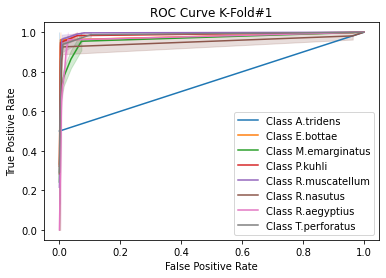

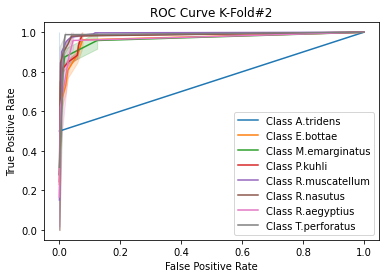

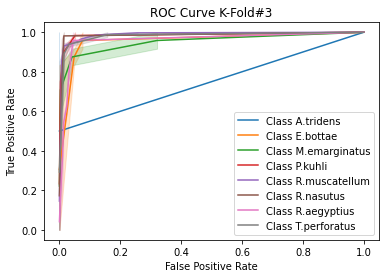

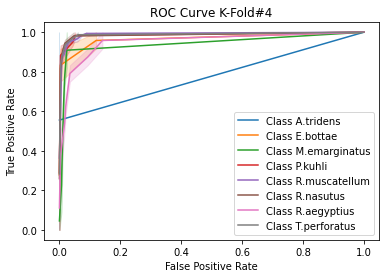

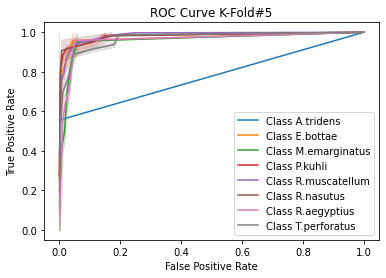

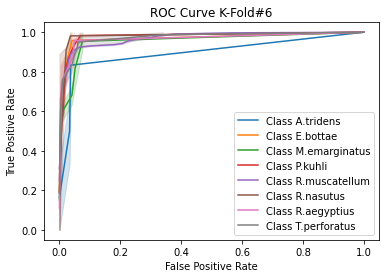

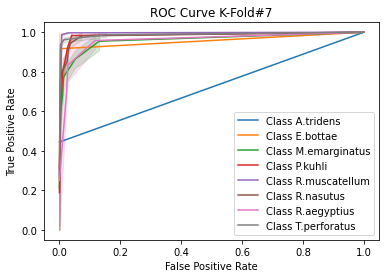

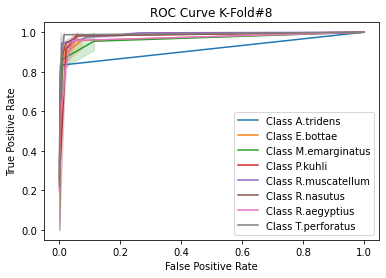

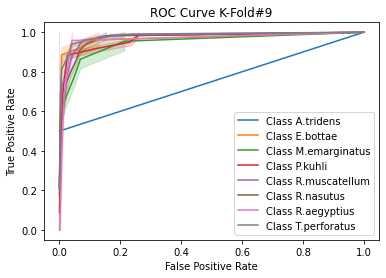

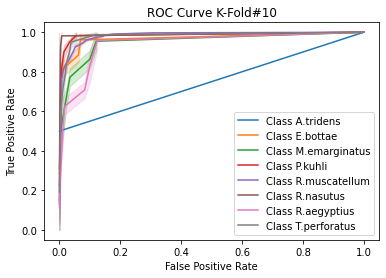

In [54]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

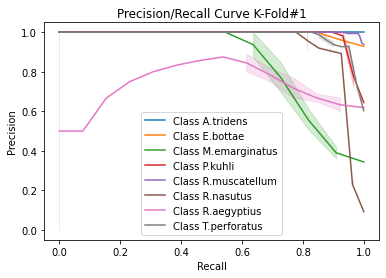

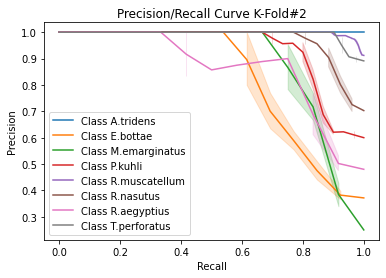

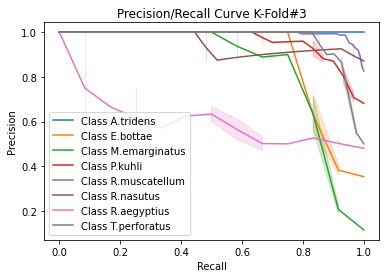

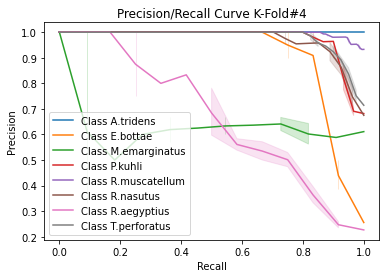

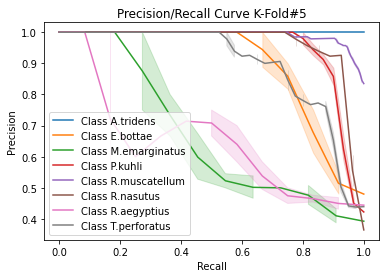

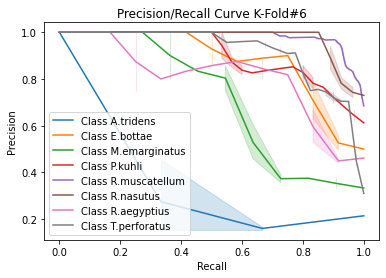

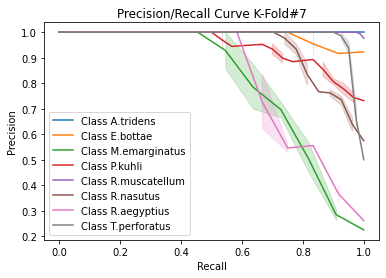

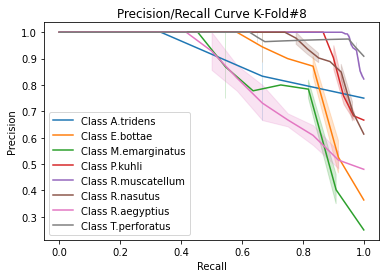

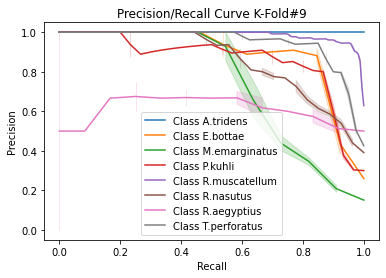

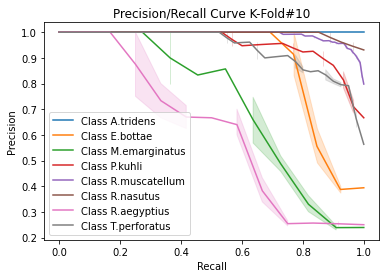

In [55]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0   8   0   0   0   2   1]
 [  0   0   0  24   2   2   1   0]
 [  0   0   0   0 164   1   1   0]
 [  0   2   0   0   0  24   1   0]
 [  0   1   1   0   0   0  10   1]
 [  0   0   1   0   4   0   0  36]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0   8   0   0   0   4   1   0]
 [  0   0   6   1   0   0   5   0]
 [  0   0   0  25   0   3   0   2]
 [  0   3   0   4 149   2   6   2]
 [  0   0   0   1   0  25   0   0]
 [  0   0   0   1   0   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   1   0]
 [  0   0   8   0   1   0   3   0]
 [  0   0   0  26   2   1   0   1]
 [  0   0   0   3 159   0   1   3]
 [  0   2   0   1   0  23   1   0]
 [  0   0   1   0   3   0   7   1]
 [  0   0   0   0   3   0   1  37]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

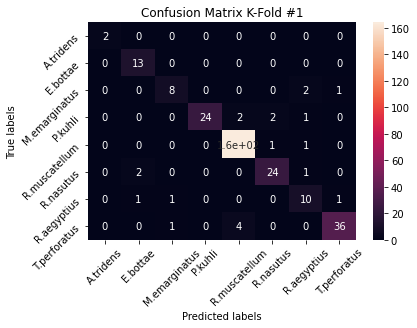

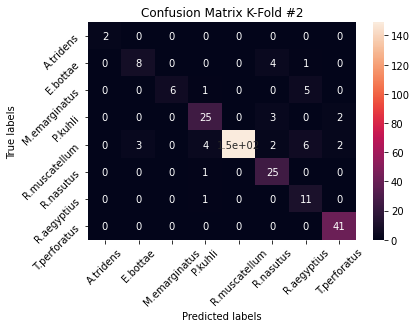

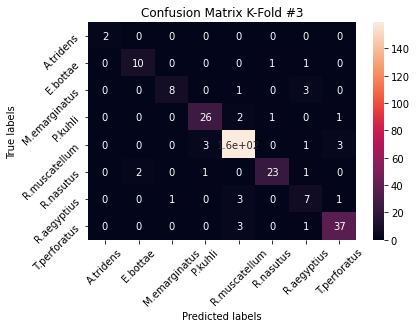

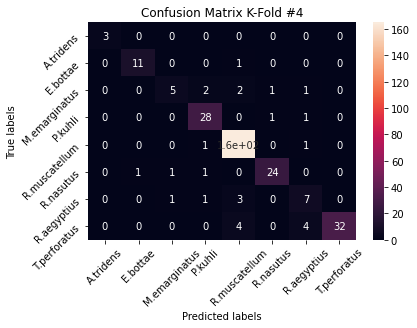

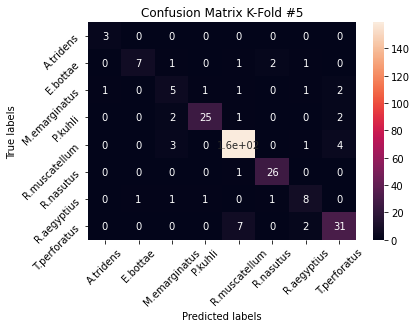

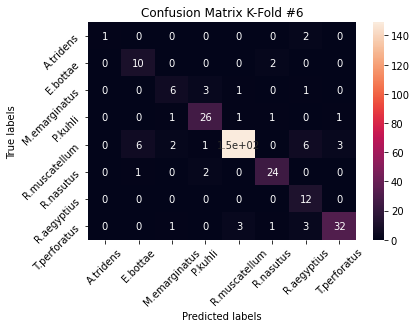

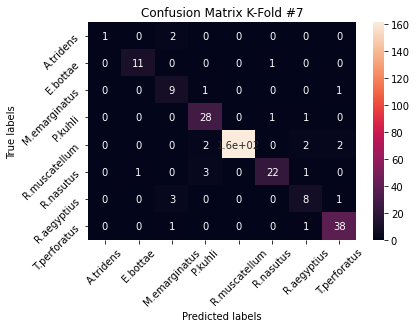

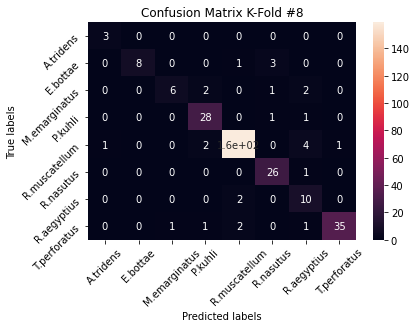

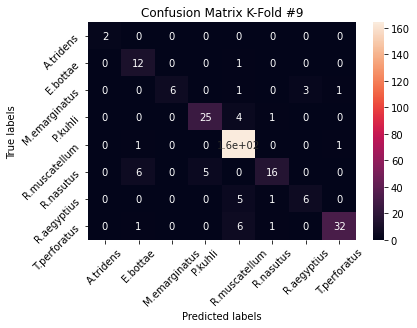

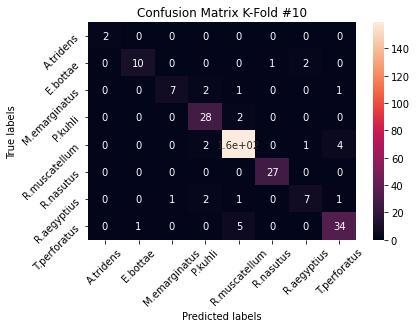

In [56]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  21    0    2    0    0    0    2    0]
 [   0  100    1    0    4   14    5    0]
 [   1    0   66   12    7    2   18    6]
 [   0    0    3  263   12   11    4    6]
 [   1   10    5   15 1588    3   23   20]
 [   0   13    1   13    1  237    4    0]
 [   0    2    8    5   14    2   86    4]
 [   0    2    4    1   34    2   12  348]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  10   0   0   0   1   0   0]
 [  0   0   6   1   0   0   1   0]
 [  0   0   0  26   1   1   0   0]
 [  0   1   0   1 158   0   2   2]
 [  0   1   0   1   0  23   0   0]
 [  0   0   0   0   1   0   8   0]
 [  0   0   0   0   3   0   1  34]]


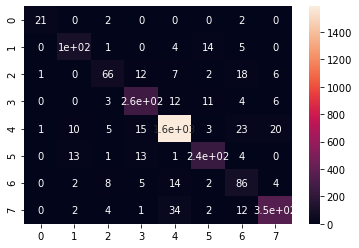

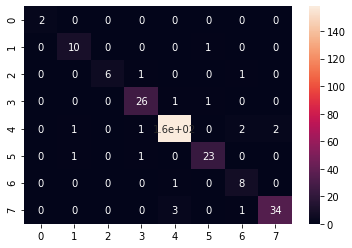

In [57]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.84 0.   0.08 0.   0.   0.   0.08 0.  ]
 [0.   0.81 0.01 0.   0.03 0.11 0.04 0.  ]
 [0.01 0.   0.59 0.11 0.06 0.02 0.16 0.05]
 [0.   0.   0.01 0.88 0.04 0.04 0.01 0.02]
 [0.   0.01 0.   0.01 0.95 0.   0.01 0.01]
 [0.   0.05 0.   0.05 0.   0.88 0.01 0.  ]
 [0.   0.02 0.07 0.04 0.12 0.02 0.71 0.03]
 [0.   0.   0.01 0.   0.08 0.   0.03 0.86]]


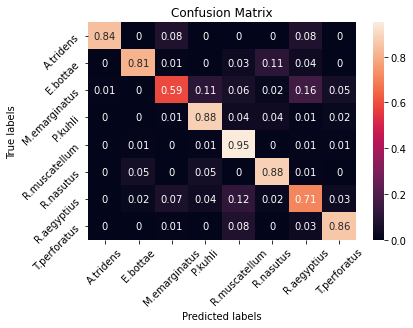

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2> V5 !!!!! K-Fold Training and Evaluation</h2>

In [60]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=48,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=48,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(112)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)
    
    lay = Dense(32)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [61]:
model = build_current_model()
model.summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 56, 85, 48)        7104      
_________________________________________________________________
batch_normalization_371 (Bat (None, 56, 85, 48)        192       
_________________________________________________________________
activation_371 (Activation)  (None, 56, 85, 48)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 28, 43, 48)        0         
_________________________________________________________________
spatial_dropout2d_212 (Spati (None, 28, 43, 48)        0         
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 14, 22, 32)        384

In [62]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.2,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/70
272/272 - 19s - loss: 1.5362 - accuracy: 0.5249 - val_loss: 1.5131 - val_accuracy: 0.5018
Epoch 2/70
272/272 - 2s - loss: 1.3568 - accuracy: 0.5580 - val_loss: 1.5519 - val_accuracy: 0.5349
Epoch 3/70
272/272 - 2s - loss: 1.2987 - accuracy: 0.5764 - val_loss: 1.3623 - val_accuracy: 0.5625
Epoch 4/70
272/272 - 2s - loss: 1.2579 - accuracy: 0.5944 - val_loss: 1.6017 - val_accuracy: 0.5000
Epoch 5/70
272/272 - 3s - loss: 1.1731 - accuracy: 0.5981 - val_loss: 1.3054 - val_accuracy: 0.5680
Epoch 6/70
272/272 - 2s - loss: 1.0925 - accuracy: 0.6248 - val_loss: 1.4663 - val_accuracy: 0.5625
Epoch 7/70
272/272 - 2s - loss: 0.9770 - accuracy: 0.6694 - val_loss: 2.2380 - val_accuracy: 0.5257
Epoch 8/70
272/272 - 2s - loss: 0.9578 - accuracy: 0.6773 - val_loss: 1.1162 - val_accuracy: 0.6066
Epoch 9/70
272/272 - 2s - loss: 0.8683 - accuracy: 0.7086 - val_loss: 1.2899 - val_accuracy: 0.5919
Epoch 10/70
272/272 - 2s - loss: 0.7974 - accuracy: 0.7307 - val_loss: 1.2636 - val_accuracy: 0.553

Epoch 13/70
272/272 - 2s - loss: 0.6511 - accuracy: 0.7845 - val_loss: 0.9618 - val_accuracy: 0.7004
Epoch 14/70
272/272 - 2s - loss: 0.6358 - accuracy: 0.7910 - val_loss: 0.9978 - val_accuracy: 0.6562
Epoch 15/70
272/272 - 2s - loss: 0.5970 - accuracy: 0.8025 - val_loss: 0.8369 - val_accuracy: 0.7390
Epoch 16/70
272/272 - 2s - loss: 0.5712 - accuracy: 0.8076 - val_loss: 0.8461 - val_accuracy: 0.6930
Epoch 17/70
272/272 - 2s - loss: 0.5882 - accuracy: 0.8020 - val_loss: 0.6631 - val_accuracy: 0.7721
Epoch 18/70
272/272 - 2s - loss: 0.5391 - accuracy: 0.8168 - val_loss: 0.6799 - val_accuracy: 0.7610
Epoch 19/70
272/272 - 2s - loss: 0.5409 - accuracy: 0.8181 - val_loss: 1.0605 - val_accuracy: 0.6691
Epoch 20/70
272/272 - 2s - loss: 0.4901 - accuracy: 0.8416 - val_loss: 0.5306 - val_accuracy: 0.8015
Epoch 21/70
272/272 - 2s - loss: 0.5054 - accuracy: 0.8306 - val_loss: 0.6909 - val_accuracy: 0.7702
Epoch 22/70
272/272 - 2s - loss: 0.4770 - accuracy: 0.8421 - val_loss: 0.6433 - val_accurac

Epoch 25/70
272/272 - 2s - loss: 0.4304 - accuracy: 0.8517 - val_loss: 0.5143 - val_accuracy: 0.8235
Epoch 26/70
272/272 - 2s - loss: 0.4135 - accuracy: 0.8674 - val_loss: 0.3964 - val_accuracy: 0.8603
Epoch 27/70
272/272 - 2s - loss: 0.4295 - accuracy: 0.8550 - val_loss: 0.4106 - val_accuracy: 0.8566
Epoch 28/70
272/272 - 2s - loss: 0.3995 - accuracy: 0.8633 - val_loss: 0.5135 - val_accuracy: 0.8272
Epoch 29/70
272/272 - 2s - loss: 0.3983 - accuracy: 0.8688 - val_loss: 0.3964 - val_accuracy: 0.8676
Epoch 30/70
272/272 - 2s - loss: 0.3658 - accuracy: 0.8720 - val_loss: 0.5503 - val_accuracy: 0.7941
Epoch 31/70
272/272 - 2s - loss: 0.3784 - accuracy: 0.8692 - val_loss: 0.3863 - val_accuracy: 0.8640
Epoch 32/70
272/272 - 2s - loss: 0.3630 - accuracy: 0.8752 - val_loss: 0.7369 - val_accuracy: 0.7463
Epoch 33/70
272/272 - 2s - loss: 0.3420 - accuracy: 0.8831 - val_loss: 0.4806 - val_accuracy: 0.8254
Epoch 34/70
272/272 - 3s - loss: 0.3185 - accuracy: 0.8844 - val_loss: 0.5559 - val_accurac

Epoch 37/70
272/272 - 2s - loss: 0.3615 - accuracy: 0.8766 - val_loss: 0.4001 - val_accuracy: 0.8474
Epoch 38/70
272/272 - 2s - loss: 0.3540 - accuracy: 0.8808 - val_loss: 0.3924 - val_accuracy: 0.8511
Epoch 39/70
272/272 - 2s - loss: 0.3398 - accuracy: 0.8895 - val_loss: 0.4302 - val_accuracy: 0.8401
Epoch 40/70
272/272 - 2s - loss: 0.3215 - accuracy: 0.8941 - val_loss: 0.4344 - val_accuracy: 0.8419
Epoch 41/70
272/272 - 2s - loss: 0.3288 - accuracy: 0.8886 - val_loss: 0.4107 - val_accuracy: 0.8603
Epoch 42/70
272/272 - 2s - loss: 0.3199 - accuracy: 0.8835 - val_loss: 0.5423 - val_accuracy: 0.8438
Epoch 43/70
272/272 - 2s - loss: 0.3135 - accuracy: 0.8941 - val_loss: 0.4703 - val_accuracy: 0.8419
Epoch 44/70
272/272 - 2s - loss: 0.3026 - accuracy: 0.8992 - val_loss: 0.2979 - val_accuracy: 0.8934
Epoch 45/70
272/272 - 2s - loss: 0.3237 - accuracy: 0.8932 - val_loss: 0.4463 - val_accuracy: 0.8566
Epoch 46/70
272/272 - 2s - loss: 0.3123 - accuracy: 0.9006 - val_loss: 0.4026 - val_accurac

Epoch 49/70
272/272 - 2s - loss: 0.2788 - accuracy: 0.9084 - val_loss: 0.3670 - val_accuracy: 0.8676
Epoch 50/70
272/272 - 2s - loss: 0.2851 - accuracy: 0.9075 - val_loss: 0.3666 - val_accuracy: 0.8676
Epoch 51/70
272/272 - 2s - loss: 0.2896 - accuracy: 0.9024 - val_loss: 0.3655 - val_accuracy: 0.8842
Epoch 52/70
272/272 - 2s - loss: 0.2816 - accuracy: 0.9084 - val_loss: 0.3987 - val_accuracy: 0.8768
Epoch 53/70
272/272 - 2s - loss: 0.2571 - accuracy: 0.9079 - val_loss: 0.3830 - val_accuracy: 0.8603
Epoch 54/70
272/272 - 2s - loss: 0.2458 - accuracy: 0.9162 - val_loss: 0.3423 - val_accuracy: 0.8805
Epoch 55/70
272/272 - 2s - loss: 0.2520 - accuracy: 0.9171 - val_loss: 0.3957 - val_accuracy: 0.8658
Epoch 56/70
272/272 - 2s - loss: 0.2668 - accuracy: 0.9157 - val_loss: 0.2977 - val_accuracy: 0.9081
Epoch 57/70
272/272 - 2s - loss: 0.2363 - accuracy: 0.9171 - val_loss: 0.3298 - val_accuracy: 0.8805
Epoch 58/70
272/272 - 1s - loss: 0.2377 - accuracy: 0.9227 - val_loss: 0.6460 - val_accurac

Epoch 61/70
272/272 - 2s - loss: 0.2263 - accuracy: 0.9203 - val_loss: 0.3624 - val_accuracy: 0.8768
Epoch 62/70
272/272 - 3s - loss: 0.2259 - accuracy: 0.9273 - val_loss: 0.4292 - val_accuracy: 0.8768
Epoch 63/70
272/272 - 2s - loss: 0.2468 - accuracy: 0.9162 - val_loss: 0.3402 - val_accuracy: 0.8915
Epoch 64/70
272/272 - 2s - loss: 0.2195 - accuracy: 0.9185 - val_loss: 0.2783 - val_accuracy: 0.9044
Epoch 65/70
272/272 - 2s - loss: 0.2238 - accuracy: 0.9203 - val_loss: 0.3864 - val_accuracy: 0.8603
Epoch 66/70
272/272 - 2s - loss: 0.2091 - accuracy: 0.9291 - val_loss: 0.2799 - val_accuracy: 0.9118
Epoch 67/70
272/272 - 2s - loss: 0.1988 - accuracy: 0.9342 - val_loss: 0.4391 - val_accuracy: 0.8621
Epoch 68/70
272/272 - 2s - loss: 0.2113 - accuracy: 0.9254 - val_loss: 0.3050 - val_accuracy: 0.8934
Epoch 69/70
272/272 - 1s - loss: 0.2097 - accuracy: 0.9319 - val_loss: 0.3140 - val_accuracy: 0.8915
Epoch 70/70
272/272 - 2s - loss: 0.2114 - accuracy: 0.9273 - val_loss: 0.2865 - val_accurac

Epoch 3/70
272/272 - 2s - loss: 1.2738 - accuracy: 0.5847 - val_loss: 1.1585 - val_accuracy: 0.5754
Epoch 4/70
272/272 - 2s - loss: 1.1675 - accuracy: 0.6096 - val_loss: 1.1809 - val_accuracy: 0.5790
Epoch 5/70
272/272 - 2s - loss: 1.0889 - accuracy: 0.6262 - val_loss: 1.5282 - val_accuracy: 0.5349
Epoch 6/70
272/272 - 2s - loss: 1.0455 - accuracy: 0.6400 - val_loss: 1.0251 - val_accuracy: 0.6140
Epoch 7/70
272/272 - 2s - loss: 0.9468 - accuracy: 0.6745 - val_loss: 1.1148 - val_accuracy: 0.6121
Epoch 8/70
272/272 - 2s - loss: 0.8584 - accuracy: 0.7026 - val_loss: 1.3156 - val_accuracy: 0.5607
Epoch 9/70
272/272 - 2s - loss: 0.7895 - accuracy: 0.7311 - val_loss: 1.1551 - val_accuracy: 0.5239
Epoch 10/70
272/272 - 2s - loss: 0.7089 - accuracy: 0.7615 - val_loss: 1.2059 - val_accuracy: 0.4688
Epoch 11/70
272/272 - 2s - loss: 0.7152 - accuracy: 0.7597 - val_loss: 0.5640 - val_accuracy: 0.8015
Epoch 12/70
272/272 - 2s - loss: 0.7012 - accuracy: 0.7693 - val_loss: 1.2722 - val_accuracy: 0.51

Epoch 15/70
272/272 - 2s - loss: 0.6295 - accuracy: 0.7892 - val_loss: 0.5073 - val_accuracy: 0.8199
Epoch 16/70
272/272 - 2s - loss: 0.6153 - accuracy: 0.7902 - val_loss: 0.7304 - val_accuracy: 0.7592
Epoch 17/70
272/272 - 2s - loss: 0.5771 - accuracy: 0.8012 - val_loss: 0.5894 - val_accuracy: 0.7868
Epoch 18/70
272/272 - 2s - loss: 0.5500 - accuracy: 0.8113 - val_loss: 0.4521 - val_accuracy: 0.8548
Epoch 19/70
272/272 - 2s - loss: 0.5294 - accuracy: 0.8306 - val_loss: 0.5925 - val_accuracy: 0.7665
Epoch 20/70
272/272 - 2s - loss: 0.5670 - accuracy: 0.8164 - val_loss: 0.6298 - val_accuracy: 0.7665
Epoch 21/70
272/272 - 2s - loss: 0.4978 - accuracy: 0.8334 - val_loss: 0.5488 - val_accuracy: 0.8180
Epoch 22/70
272/272 - 2s - loss: 0.5172 - accuracy: 0.8353 - val_loss: 1.2047 - val_accuracy: 0.5404
Epoch 23/70
272/272 - 2s - loss: 0.4614 - accuracy: 0.8449 - val_loss: 0.6812 - val_accuracy: 0.7537
Epoch 24/70
272/272 - 2s - loss: 0.4719 - accuracy: 0.8468 - val_loss: 0.4994 - val_accurac

Epoch 27/70
272/272 - 2s - loss: 0.4013 - accuracy: 0.8725 - val_loss: 0.3969 - val_accuracy: 0.8511
Epoch 28/70
272/272 - 2s - loss: 0.3741 - accuracy: 0.8776 - val_loss: 0.6130 - val_accuracy: 0.7978
Epoch 29/70
272/272 - 2s - loss: 0.3669 - accuracy: 0.8656 - val_loss: 0.7337 - val_accuracy: 0.7206
Epoch 30/70
272/272 - 2s - loss: 0.3797 - accuracy: 0.8707 - val_loss: 0.3557 - val_accuracy: 0.8732
Epoch 31/70
272/272 - 2s - loss: 0.3762 - accuracy: 0.8711 - val_loss: 0.5494 - val_accuracy: 0.8180
Epoch 32/70
272/272 - 2s - loss: 0.3549 - accuracy: 0.8905 - val_loss: 0.5121 - val_accuracy: 0.8162
Epoch 33/70
272/272 - 2s - loss: 0.3601 - accuracy: 0.8799 - val_loss: 0.4883 - val_accuracy: 0.8290
Epoch 34/70
272/272 - 2s - loss: 0.3459 - accuracy: 0.8845 - val_loss: 0.3895 - val_accuracy: 0.8566
Epoch 35/70
272/272 - 2s - loss: 0.3918 - accuracy: 0.8757 - val_loss: 0.5044 - val_accuracy: 0.8051
Epoch 36/70
272/272 - 2s - loss: 0.3415 - accuracy: 0.8868 - val_loss: 0.7357 - val_accurac

In [63]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.94166667 0.87352758 0.80005772 0.86074348 0.96579882 0.88162974
 0.62379467 0.92400188]
precision sdev by class [0.11814539 0.10621876 0.158668   0.06731558 0.00991187 0.07175804
 0.11511869 0.06932501]
macro precision mean 0.8589025682969333
macro precision sdev 0.03905579835414308
recall mean [0.86666667 0.78589744 0.62424242 0.90264368 0.96214198 0.85868946
 0.73846154 0.90542683]
recall sdev [0.26666667 0.14265377 0.17431487 0.05794757 0.01595519 0.06162282
 0.17879445 0.07057355]
macro recall mean 0.8305212515605976
macro recall sdev 0.0394503486508546
f1 mean [0.86571429 0.81606688 0.66517926 0.8785924  0.96385153 0.86723484
 0.6600528  0.91124798]
f1 sdev [0.19495682 0.09077628 0.10079386 0.04351853 0.00807972 0.04669347
 0.10671736 0.04361345]
macro f1 mean 0.8284924965761226
macro f1 sdev 0.04164577253839024
accuracy mean 0.9095311434291874
accuracy sdev 0.018976939198604555


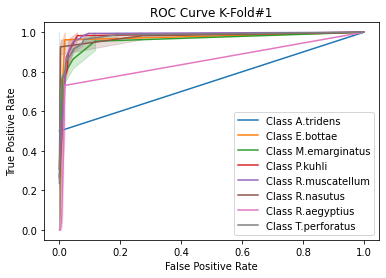

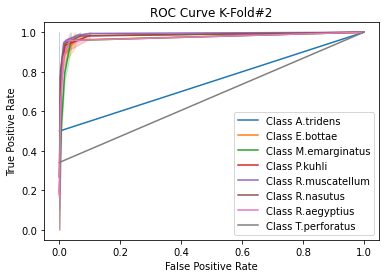

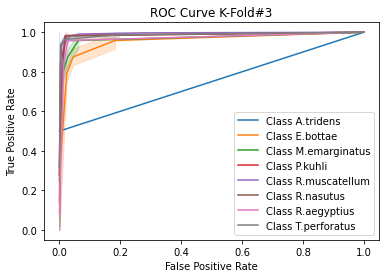

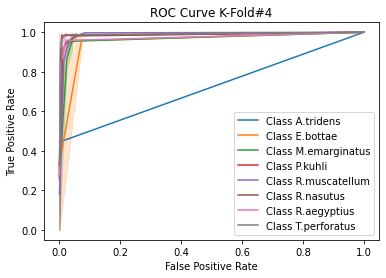

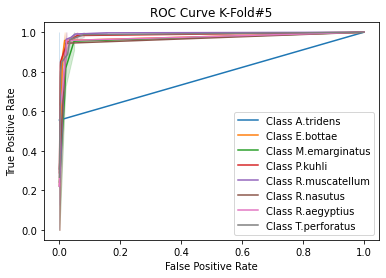

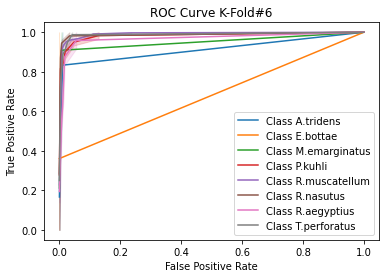

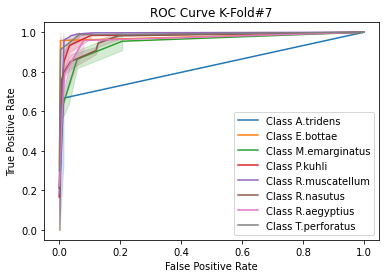

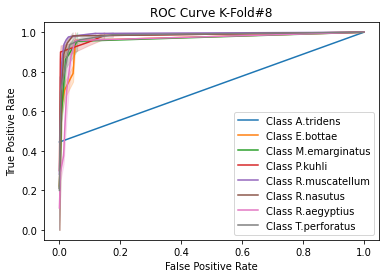

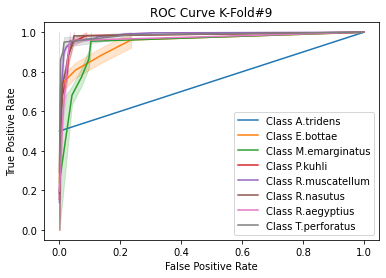

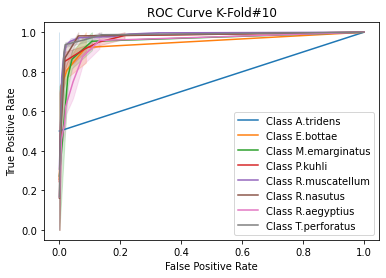

In [64]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

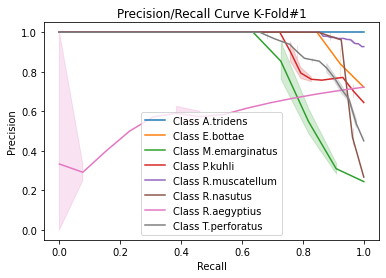

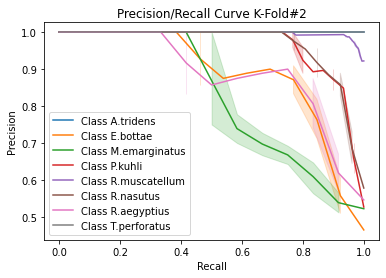

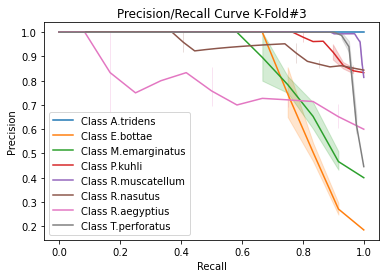

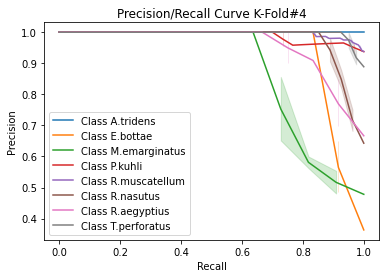

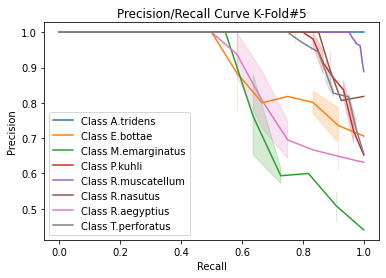

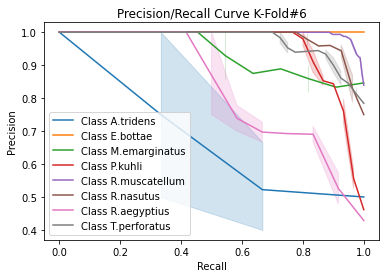

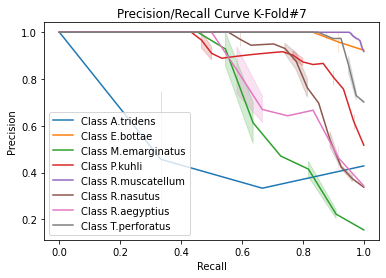

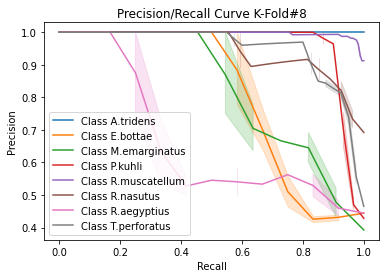

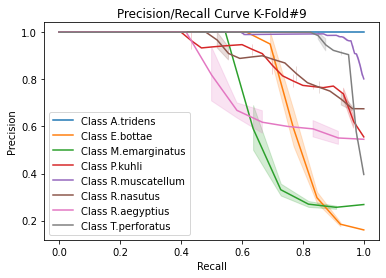

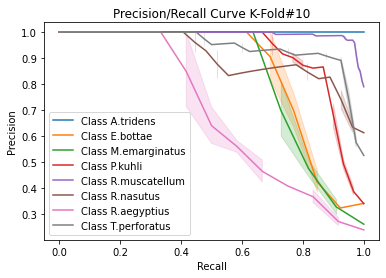

In [65]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  10   0   1   1   1   0   0]
 [  0   0  10   0   0   0   0   1]
 [  0   0   2  23   2   0   1   1]
 [  0   0   1   0 155   0   2   8]
 [  0   0   0   3   0  23   1   0]
 [  1   0   7   0   0   0   5   0]
 [  0   0   2   0   2   0   0  37]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0   8   0   0   3   2   0   0]
 [  0   0   6   1   0   0   5   0]
 [  0   0   2  26   2   0   0   0]
 [  0   1   0   0 161   0   3   1]
 [  0   0   0   3   1  22   0   0]
 [  0   0   0   1   0   0  11   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0   9   0   0   0   2   1   0]
 [  0   0  10   1   1   0   0   0]
 [  0   0   1  28   1   0   0   0]
 [  0   0   1   1 162   0   2   0]
 [  0   1   0   3   1  21   1   0]
 [  0   0   3   0   0   0   9   0]
 [  0   0   1   0   1   0   1  38]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

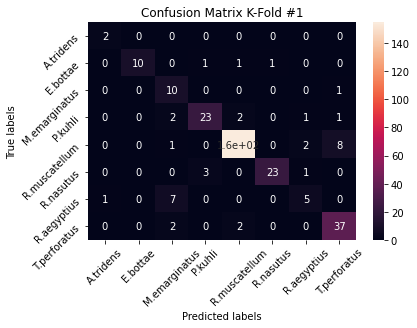

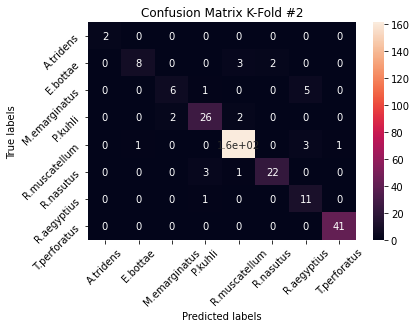

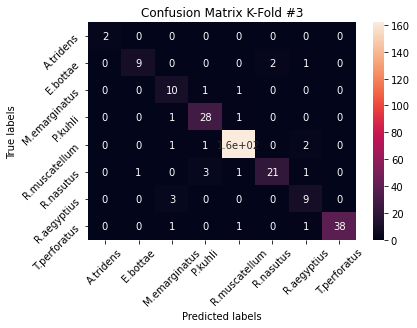

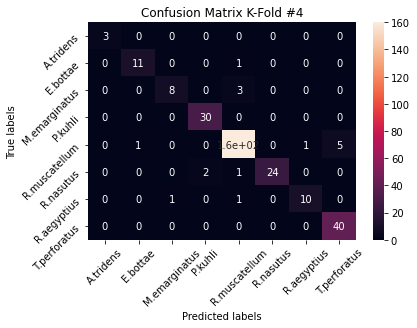

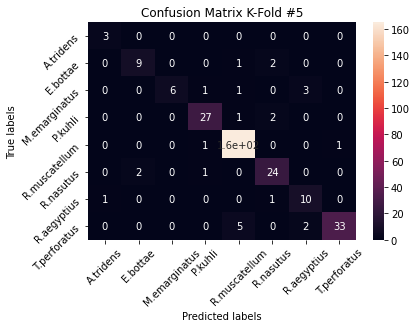

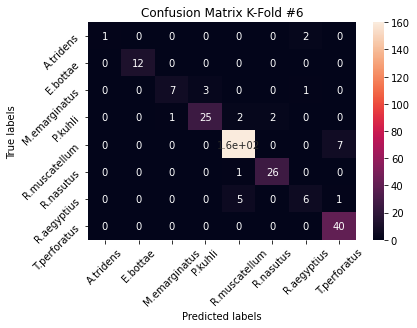

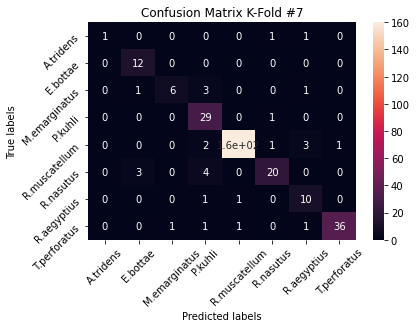

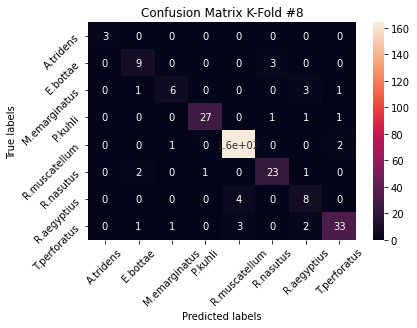

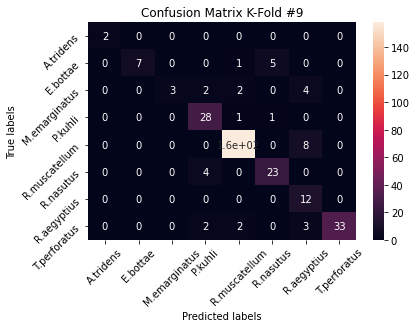

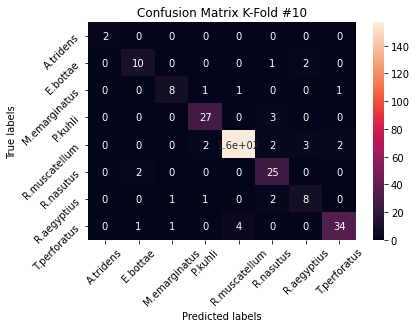

In [66]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  21    0    0    0    0    1    3    0]
 [   0   97    0    1    7   16    3    0]
 [   0    2   70   12    8    0   17    3]
 [   0    0    6  270    9   10    2    2]
 [   0    2    3    6 1602    3   22   27]
 [   0   10    0   21    4  231    3    0]
 [   2    0   12    3   11    3   89    1]
 [   0    2    6    3   18    0    9  365]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0   9   0   0   0   1   0   0]
 [  0   0   7   1   0   0   1   0]
 [  0   0   0  27   0   1   0   0]
 [  0   0   0   0 160   0   2   2]
 [  0   1   0   2   0  23   0   0]
 [  0   0   1   0   1   0   8   0]
 [  0   0   0   0   1   0   0  36]]


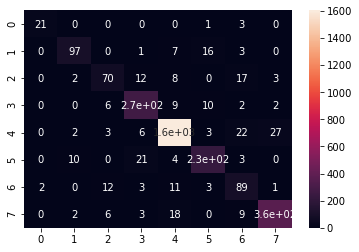

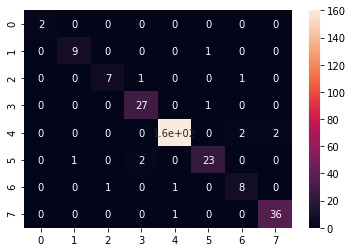

In [67]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.84 0.   0.   0.   0.   0.04 0.12 0.  ]
 [0.   0.78 0.   0.01 0.06 0.13 0.02 0.  ]
 [0.   0.02 0.62 0.11 0.07 0.   0.15 0.03]
 [0.   0.   0.02 0.9  0.03 0.03 0.01 0.01]
 [0.   0.   0.   0.   0.96 0.   0.01 0.02]
 [0.   0.04 0.   0.08 0.01 0.86 0.01 0.  ]
 [0.02 0.   0.1  0.02 0.09 0.02 0.74 0.01]
 [0.   0.   0.01 0.01 0.04 0.   0.02 0.91]]


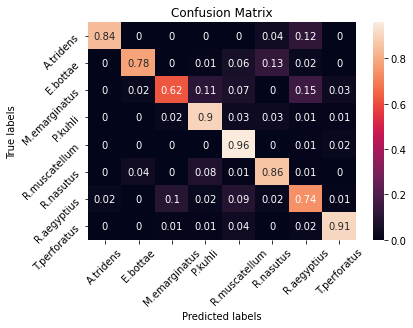

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

# V6 Load Data

In [69]:
X_all = []
Y_all = []

image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((85, 56))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [70]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 56, 85, 3)
(3018,)


In [71]:
def build_current_model():
    inp = Input(shape=(56,85,3))
    lay = Convolution2D(filters=168,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.2)(lay)

    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=232,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=104,kernel_size=(5,5),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.4)(lay)

    lay = Flatten()(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [72]:
model = build_current_model()
model.summary()

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 56, 85, 3)]       0         
_________________________________________________________________
conv2d_256 (Conv2D)          (None, 28, 43, 168)       24864     
_________________________________________________________________
batch_normalization_437 (Bat (None, 28, 43, 168)       672       
_________________________________________________________________
activation_437 (Activation)  (None, 28, 43, 168)       0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 14, 22, 168)       0         
_________________________________________________________________
dropout_181 (Dropout)        (None, 14, 22, 168)       0         
_________________________________________________________________
conv2d_257 (Conv2D)          (None, 7, 11, 56)         461

In [73]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=70,
              validation_split=0.2,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/70
272/272 - 16s - loss: 1.4913 - accuracy: 0.5368 - val_loss: 1.2799 - val_accuracy: 0.5662
Epoch 2/70
272/272 - 2s - loss: 1.2452 - accuracy: 0.5902 - val_loss: 1.2631 - val_accuracy: 0.5478
Epoch 3/70
272/272 - 2s - loss: 1.0592 - accuracy: 0.6427 - val_loss: 1.7000 - val_accuracy: 0.5239
Epoch 4/70
272/272 - 2s - loss: 0.8557 - accuracy: 0.7049 - val_loss: 2.2308 - val_accuracy: 0.5864
Epoch 5/70
272/272 - 2s - loss: 0.6854 - accuracy: 0.7666 - val_loss: 1.9604 - val_accuracy: 0.2978
Epoch 6/70
272/272 - 2s - loss: 0.6232 - accuracy: 0.7753 - val_loss: 1.3682 - val_accuracy: 0.6526
Epoch 7/70
272/272 - 2s - loss: 0.5650 - accuracy: 0.8029 - val_loss: 0.6496 - val_accuracy: 0.7629
Epoch 8/70
272/272 - 2s - loss: 0.5431 - accuracy: 0.8076 - val_loss: 0.9628 - val_accuracy: 0.6415
Epoch 9/70
272/272 - 2s - loss: 0.4910 - accuracy: 0.8297 - val_loss: 1.0860 - val_accuracy: 0.6507
Epoch 10/70
272/272 - 2s - loss: 0.4665 - accuracy: 0.8398 - val_loss: 1.1810 - val_accuracy: 0.599

Epoch 13/70
272/272 - 2s - loss: 0.3905 - accuracy: 0.8536 - val_loss: 0.7018 - val_accuracy: 0.7390
Epoch 14/70
272/272 - 2s - loss: 0.3809 - accuracy: 0.8688 - val_loss: 0.8450 - val_accuracy: 0.7040
Epoch 15/70
272/272 - 2s - loss: 0.3855 - accuracy: 0.8683 - val_loss: 0.7465 - val_accuracy: 0.7298
Epoch 16/70
272/272 - 2s - loss: 0.3641 - accuracy: 0.8702 - val_loss: 0.4485 - val_accuracy: 0.8235
Epoch 17/70
272/272 - 2s - loss: 0.3513 - accuracy: 0.8821 - val_loss: 0.5475 - val_accuracy: 0.7776
Epoch 18/70
272/272 - 2s - loss: 0.3167 - accuracy: 0.8927 - val_loss: 0.4455 - val_accuracy: 0.8309
Epoch 19/70
272/272 - 2s - loss: 0.3319 - accuracy: 0.8913 - val_loss: 0.3923 - val_accuracy: 0.8493
Epoch 20/70
272/272 - 2s - loss: 0.3209 - accuracy: 0.8904 - val_loss: 0.5226 - val_accuracy: 0.7904
Epoch 21/70
272/272 - 2s - loss: 0.3032 - accuracy: 0.8932 - val_loss: 0.4657 - val_accuracy: 0.8364
Epoch 22/70
272/272 - 2s - loss: 0.2629 - accuracy: 0.9075 - val_loss: 0.3986 - val_accurac

Epoch 25/70
272/272 - 2s - loss: 0.2701 - accuracy: 0.9029 - val_loss: 0.9786 - val_accuracy: 0.6985
Epoch 26/70
272/272 - 2s - loss: 0.2999 - accuracy: 0.8964 - val_loss: 0.4898 - val_accuracy: 0.8217
Epoch 27/70
272/272 - 2s - loss: 0.2592 - accuracy: 0.9157 - val_loss: 0.4215 - val_accuracy: 0.8585
Epoch 28/70
272/272 - 2s - loss: 0.2403 - accuracy: 0.9185 - val_loss: 0.4038 - val_accuracy: 0.8548
Epoch 29/70
272/272 - 2s - loss: 0.2228 - accuracy: 0.9203 - val_loss: 0.6901 - val_accuracy: 0.7592
Epoch 30/70
272/272 - 2s - loss: 0.2252 - accuracy: 0.9217 - val_loss: 0.3214 - val_accuracy: 0.9081
Epoch 31/70
272/272 - 2s - loss: 0.2464 - accuracy: 0.9125 - val_loss: 0.3440 - val_accuracy: 0.8713
Epoch 32/70
272/272 - 2s - loss: 0.2314 - accuracy: 0.9227 - val_loss: 0.6833 - val_accuracy: 0.7647
Epoch 33/70
272/272 - 2s - loss: 0.2187 - accuracy: 0.9190 - val_loss: 0.3833 - val_accuracy: 0.8621
Epoch 34/70
272/272 - 2s - loss: 0.2007 - accuracy: 0.9291 - val_loss: 0.3691 - val_accurac

Epoch 37/70
272/272 - 2s - loss: 0.1935 - accuracy: 0.9305 - val_loss: 0.5658 - val_accuracy: 0.7978
Epoch 38/70
272/272 - 2s - loss: 0.1825 - accuracy: 0.9369 - val_loss: 0.5467 - val_accuracy: 0.7923
Epoch 39/70
272/272 - 2s - loss: 0.1904 - accuracy: 0.9296 - val_loss: 0.3283 - val_accuracy: 0.8768
Epoch 40/70
272/272 - 2s - loss: 0.1863 - accuracy: 0.9309 - val_loss: 0.4119 - val_accuracy: 0.8493
Epoch 41/70
272/272 - 2s - loss: 0.1564 - accuracy: 0.9411 - val_loss: 0.3437 - val_accuracy: 0.8805
Epoch 42/70
272/272 - 2s - loss: 0.1914 - accuracy: 0.9360 - val_loss: 0.3056 - val_accuracy: 0.8860
Epoch 43/70
272/272 - 2s - loss: 0.1756 - accuracy: 0.9374 - val_loss: 1.0019 - val_accuracy: 0.6783
Epoch 44/70
272/272 - 2s - loss: 0.1677 - accuracy: 0.9397 - val_loss: 0.3216 - val_accuracy: 0.8897
Epoch 45/70
272/272 - 2s - loss: 0.1636 - accuracy: 0.9443 - val_loss: 0.3635 - val_accuracy: 0.8621
Epoch 46/70
272/272 - 2s - loss: 0.1597 - accuracy: 0.9452 - val_loss: 0.3904 - val_accurac

Epoch 49/70
272/272 - 2s - loss: 0.1440 - accuracy: 0.9526 - val_loss: 0.2737 - val_accuracy: 0.8915
Epoch 50/70
272/272 - 2s - loss: 0.1562 - accuracy: 0.9471 - val_loss: 0.3780 - val_accuracy: 0.8548
Epoch 51/70
272/272 - 2s - loss: 0.1580 - accuracy: 0.9489 - val_loss: 0.3093 - val_accuracy: 0.8952
Epoch 52/70
272/272 - 2s - loss: 0.1336 - accuracy: 0.9540 - val_loss: 0.3991 - val_accuracy: 0.8732
Epoch 53/70
272/272 - 2s - loss: 0.1480 - accuracy: 0.9507 - val_loss: 0.3006 - val_accuracy: 0.8971
Epoch 54/70
272/272 - 2s - loss: 0.1314 - accuracy: 0.9544 - val_loss: 0.2448 - val_accuracy: 0.9228
Epoch 55/70
272/272 - 2s - loss: 0.1217 - accuracy: 0.9558 - val_loss: 0.2830 - val_accuracy: 0.9173
Epoch 56/70
272/272 - 2s - loss: 0.1647 - accuracy: 0.9438 - val_loss: 0.4216 - val_accuracy: 0.8529
Epoch 57/70
272/272 - 2s - loss: 0.1351 - accuracy: 0.9489 - val_loss: 0.5001 - val_accuracy: 0.8143
Epoch 58/70
272/272 - 2s - loss: 0.1491 - accuracy: 0.9540 - val_loss: 0.3215 - val_accurac

Epoch 61/70
272/272 - 2s - loss: 0.1591 - accuracy: 0.9461 - val_loss: 0.2994 - val_accuracy: 0.8934
Epoch 62/70
272/272 - 2s - loss: 0.1120 - accuracy: 0.9618 - val_loss: 0.2822 - val_accuracy: 0.8971
Epoch 63/70
272/272 - 2s - loss: 0.1194 - accuracy: 0.9581 - val_loss: 0.4720 - val_accuracy: 0.8327
Epoch 64/70
272/272 - 2s - loss: 0.1351 - accuracy: 0.9461 - val_loss: 0.3993 - val_accuracy: 0.8897
Epoch 65/70
272/272 - 2s - loss: 0.1312 - accuracy: 0.9576 - val_loss: 0.3407 - val_accuracy: 0.8805
Epoch 66/70
272/272 - 2s - loss: 0.1350 - accuracy: 0.9507 - val_loss: 0.2858 - val_accuracy: 0.8915
Epoch 67/70
272/272 - 2s - loss: 0.1148 - accuracy: 0.9535 - val_loss: 0.3425 - val_accuracy: 0.8842
Epoch 68/70
272/272 - 2s - loss: 0.1108 - accuracy: 0.9595 - val_loss: 0.3048 - val_accuracy: 0.8952
Epoch 69/70
272/272 - 2s - loss: 0.1305 - accuracy: 0.9507 - val_loss: 0.2782 - val_accuracy: 0.9062
Epoch 70/70
272/272 - 2s - loss: 0.0991 - accuracy: 0.9636 - val_loss: 0.2793 - val_accurac

Epoch 3/70
272/272 - 2s - loss: 0.9615 - accuracy: 0.6713 - val_loss: 1.1341 - val_accuracy: 0.6526
Epoch 4/70
272/272 - 2s - loss: 0.7797 - accuracy: 0.7394 - val_loss: 1.6511 - val_accuracy: 0.6011
Epoch 5/70
272/272 - 2s - loss: 0.6933 - accuracy: 0.7578 - val_loss: 0.9892 - val_accuracy: 0.6121
Epoch 6/70
272/272 - 2s - loss: 0.6015 - accuracy: 0.7914 - val_loss: 1.3674 - val_accuracy: 0.6158
Epoch 7/70
272/272 - 2s - loss: 0.5783 - accuracy: 0.8025 - val_loss: 0.7213 - val_accuracy: 0.7206
Epoch 8/70
272/272 - 2s - loss: 0.5277 - accuracy: 0.8177 - val_loss: 1.0592 - val_accuracy: 0.6268
Epoch 9/70
272/272 - 2s - loss: 0.5046 - accuracy: 0.8246 - val_loss: 0.6619 - val_accuracy: 0.7500
Epoch 10/70
272/272 - 2s - loss: 0.4672 - accuracy: 0.8333 - val_loss: 0.7354 - val_accuracy: 0.7426
Epoch 11/70
272/272 - 2s - loss: 0.4148 - accuracy: 0.8577 - val_loss: 0.8251 - val_accuracy: 0.7537
Epoch 12/70
272/272 - 2s - loss: 0.4204 - accuracy: 0.8628 - val_loss: 0.5770 - val_accuracy: 0.79

Epoch 15/70
272/272 - 2s - loss: 0.3610 - accuracy: 0.8739 - val_loss: 0.6185 - val_accuracy: 0.7868
Epoch 16/70
272/272 - 2s - loss: 0.3369 - accuracy: 0.8794 - val_loss: 0.9131 - val_accuracy: 0.6562
Epoch 17/70
272/272 - 2s - loss: 0.3761 - accuracy: 0.8716 - val_loss: 0.7324 - val_accuracy: 0.7224
Epoch 18/70
272/272 - 2s - loss: 0.3600 - accuracy: 0.8753 - val_loss: 0.7140 - val_accuracy: 0.7518
Epoch 19/70
272/272 - 2s - loss: 0.3164 - accuracy: 0.8873 - val_loss: 0.5371 - val_accuracy: 0.8125
Epoch 20/70
272/272 - 2s - loss: 0.2941 - accuracy: 0.9001 - val_loss: 0.4761 - val_accuracy: 0.8309
Epoch 21/70
272/272 - 2s - loss: 0.3244 - accuracy: 0.8891 - val_loss: 0.4688 - val_accuracy: 0.8290
Epoch 22/70
272/272 - 2s - loss: 0.2829 - accuracy: 0.9015 - val_loss: 0.3402 - val_accuracy: 0.8548
Epoch 23/70
272/272 - 2s - loss: 0.2840 - accuracy: 0.9043 - val_loss: 0.5669 - val_accuracy: 0.8051
Epoch 24/70
272/272 - 2s - loss: 0.2789 - accuracy: 0.9057 - val_loss: 0.6253 - val_accurac

Epoch 27/70
272/272 - 2s - loss: 0.2626 - accuracy: 0.9126 - val_loss: 0.3685 - val_accuracy: 0.8732
Epoch 28/70
272/272 - 2s - loss: 0.2617 - accuracy: 0.9121 - val_loss: 0.4747 - val_accuracy: 0.8309
Epoch 29/70
272/272 - 2s - loss: 0.2469 - accuracy: 0.9103 - val_loss: 0.5181 - val_accuracy: 0.8088
Epoch 30/70
272/272 - 2s - loss: 0.2390 - accuracy: 0.9149 - val_loss: 0.5201 - val_accuracy: 0.8033
Epoch 31/70
272/272 - 2s - loss: 0.2138 - accuracy: 0.9227 - val_loss: 0.3632 - val_accuracy: 0.8695
Epoch 32/70
272/272 - 2s - loss: 0.2274 - accuracy: 0.9199 - val_loss: 0.3547 - val_accuracy: 0.8658
Epoch 33/70
272/272 - 2s - loss: 0.2111 - accuracy: 0.9250 - val_loss: 0.3211 - val_accuracy: 0.8879
Epoch 34/70
272/272 - 2s - loss: 0.2204 - accuracy: 0.9213 - val_loss: 0.3733 - val_accuracy: 0.8621
Epoch 35/70
272/272 - 2s - loss: 0.2169 - accuracy: 0.9227 - val_loss: 0.4054 - val_accuracy: 0.8456
Epoch 36/70
272/272 - 2s - loss: 0.2059 - accuracy: 0.9305 - val_loss: 0.4251 - val_accurac

/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.70833333 0.84984288 0.84119048 0.88372779 0.93376173 0.87824389
 0.58430565 0.90600093]
precision sdev by class [0.34810998 0.13739019 0.14480341 0.07466092 0.0538839  0.0821208
 0.17484028 0.06353245]
macro precision mean 0.823175835340163
macro precision sdev 0.0682142317809667
recall mean [0.71666667 0.85448718 0.57045455 0.79850575 0.963942   0.88133903
 0.68012821 0.81182927]
recall sdev [0.36552854 0.09607048 0.19957628 0.12669154 0.01848859 0.08234567
 0.19399791 0.12704403]
macro recall mean 0.7846690798777207
macro recall sdev 0.08545012984731049
f1 mean [0.68904762 0.84117894 0.64193937 0.8276777  0.94748932 0.87514648
 0.61438551 0.84771184]
f1 sdev [0.33881245 0.07413634 0.17901114 0.06021344 0.0281001  0.05492414
 0.16043984 0.07757142]
macro f1 mean 0.7855720980070382
macro f1 sdev 0.08374175665175045
accuracy mean 0.8873369122791578
accuracy sdev 0.038435127847251505


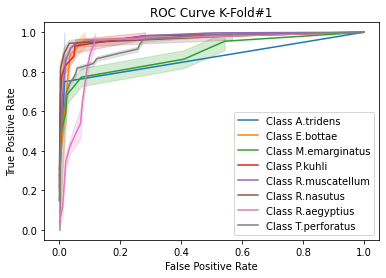

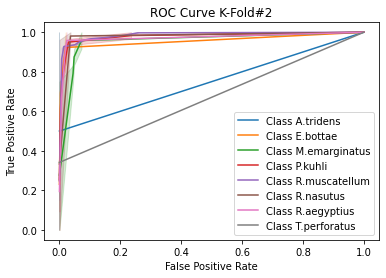

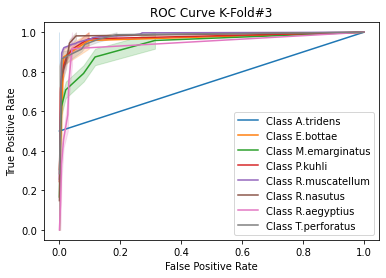

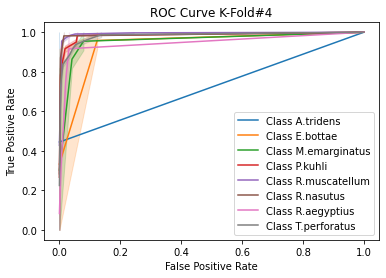

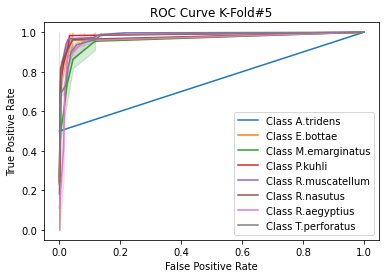

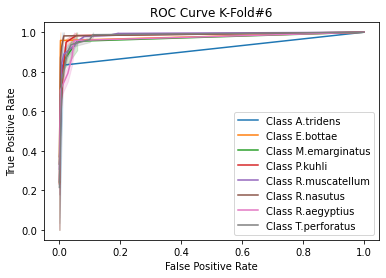

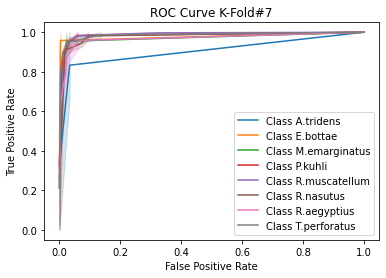

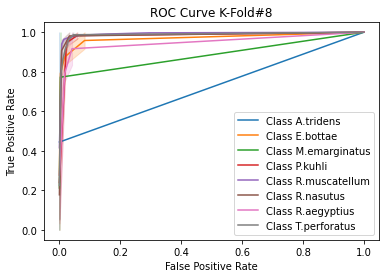

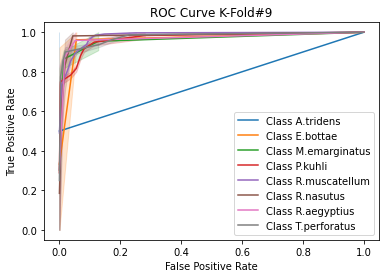

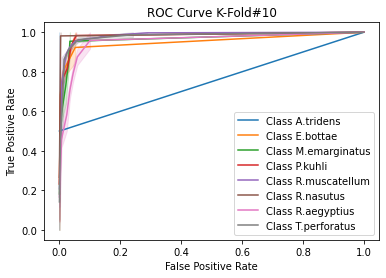

In [75]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

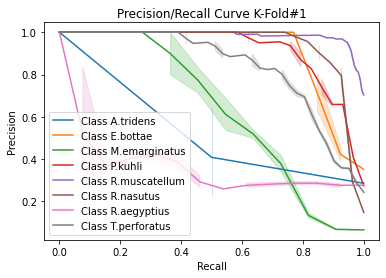

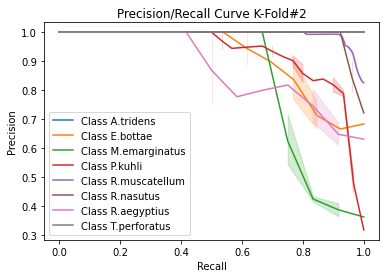

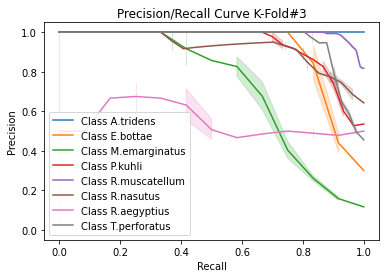

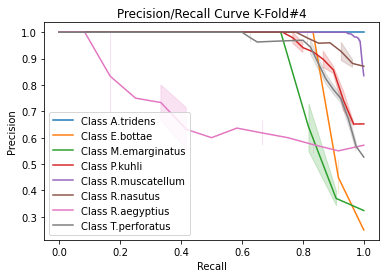

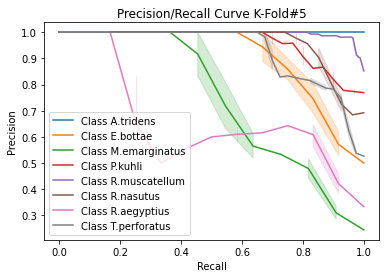

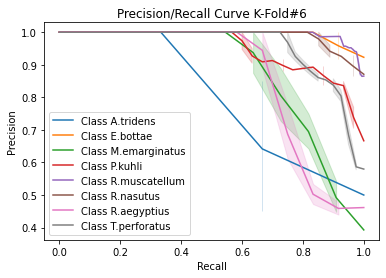

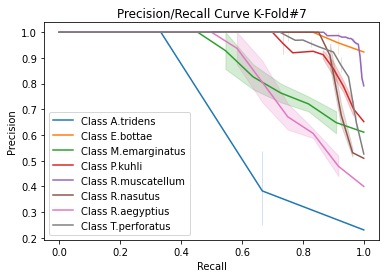

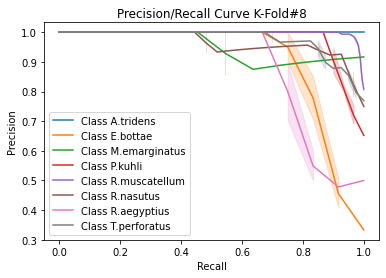

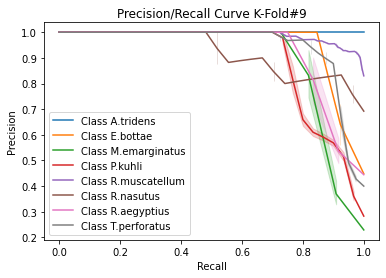

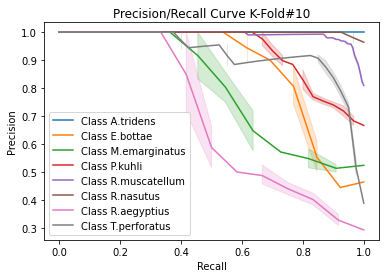

In [76]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  1   0   0   0   1   0   0   0]
 [  0  11   0   0   1   0   1   0]
 [  0   0   1   0   9   0   1   0]
 [  2   0   0  16   8   3   0   0]
 [  0   0   0   0 163   0   2   1]
 [  0   0   0   0   1  23   3   0]
 [  0   0   0   0   8   0   5   0]
 [  0   0   0   0  17   0   4  20]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   1   0   0   0]
 [  0   0   7   3   1   0   1   0]
 [  0   0   0  25   3   2   0   0]
 [  0   5   0   1 159   0   1   0]
 [  0   0   0   0   1  25   0   0]
 [  0   1   0   1   1   0   9   0]
 [  0   1   0   0   4   0   0  36]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0   8   0   0   2   1   1   0]
 [  0   0   8   0   1   0   3   0]
 [  1   0   4  18   3   1   0   3]
 [  0   0   0   0 160   0   3   3]
 [  0   0   2   0   4  20   1   0]
 [  0   0   0   0   2   0  10   0]
 [  0   0   0   0   1   0   3  37]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

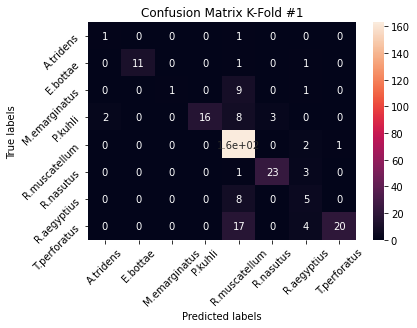

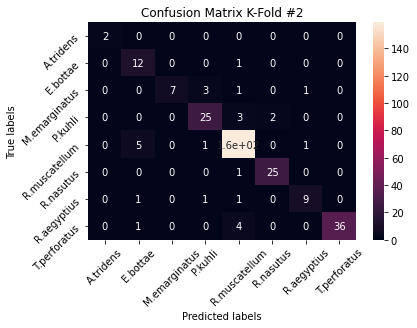

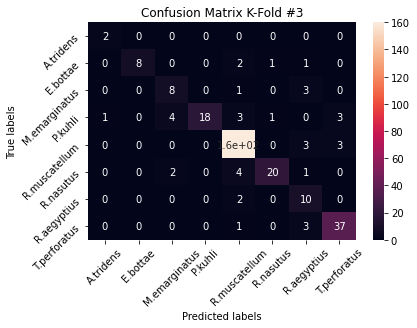

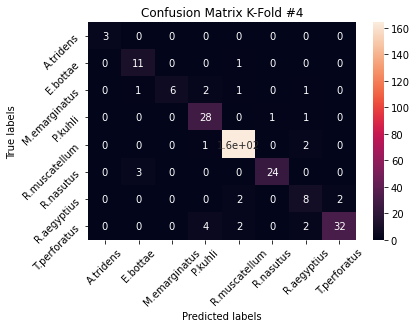

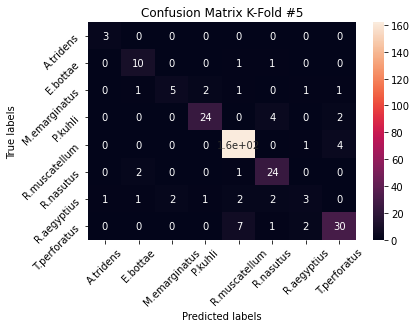

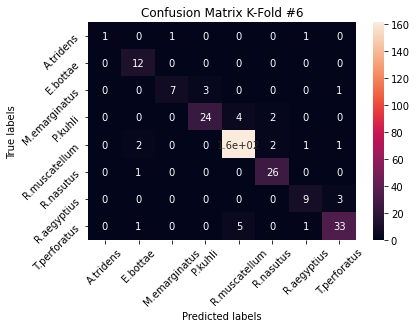

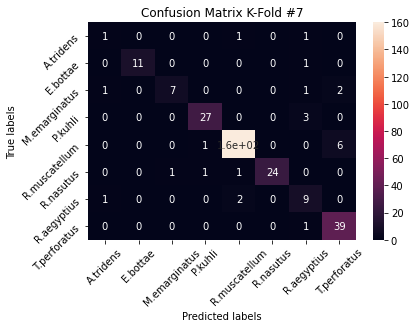

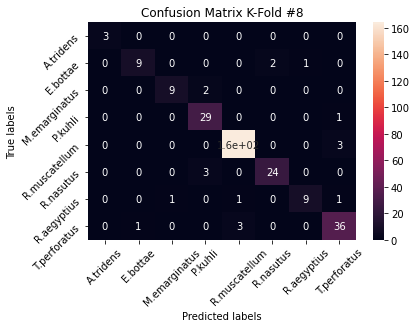

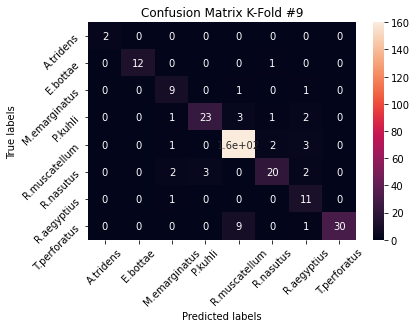

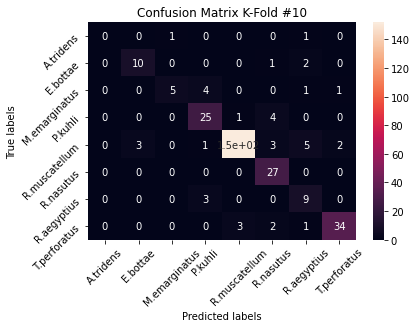

In [77]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  18    0    2    0    2    0    3    0]
 [   0  106    0    0    6    6    6    0]
 [   1    2   64   16   14    0   10    5]
 [   3    0    5  239   22   18    6    6]
 [   0   10    1    4 1605    7   18   20]
 [   0    6    5    7    8  237    6    0]
 [   2    2    4    5   18    2   82    6]
 [   0    3    0    4   51    3   15  327]]

average of all confuion matrices
 [[  1   0   0   0   0   0   0   0]
 [  0  10   0   0   0   0   0   0]
 [  0   0   6   1   1   0   1   0]
 [  0   0   0  23   2   1   0   0]
 [  0   1   0   0 160   0   1   2]
 [  0   0   0   0   0  23   0   0]
 [  0   0   0   0   1   0   8   0]
 [  0   0   0   0   5   0   1  32]]


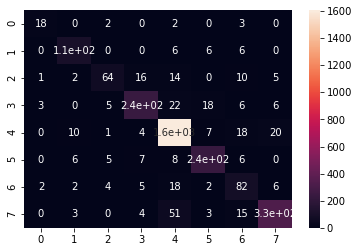

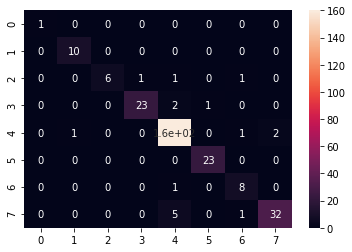

In [78]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.72 0.   0.08 0.   0.08 0.   0.12 0.  ]
 [0.   0.85 0.   0.   0.05 0.05 0.05 0.  ]
 [0.01 0.02 0.57 0.14 0.12 0.   0.09 0.04]
 [0.01 0.   0.02 0.8  0.07 0.06 0.02 0.02]
 [0.   0.01 0.   0.   0.96 0.   0.01 0.01]
 [0.   0.02 0.02 0.03 0.03 0.88 0.02 0.  ]
 [0.02 0.02 0.03 0.04 0.15 0.02 0.68 0.05]
 [0.   0.01 0.   0.01 0.13 0.01 0.04 0.81]]


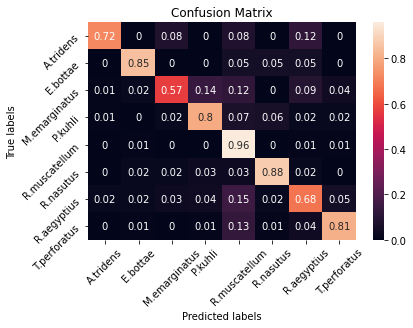

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);